


#1 DATA EXPORTATION - La Liga DEFENDERS

In [ ]:
import requests
import pandas as pd
import time
import numpy as np # Import numpy for robust percentage calculations

# API key - Replace with your actual API key
api_key = 'ba53d657e0973b0ae6f5a6b0be2f88d1' # Keep this as is, Canvas will inject the key

# Request headers
headers = {
    'x-apisports-key': api_key
}

# La Liga ID and season
league_id = 140 # La Liga
season = 2023
page = 1
all_players = []

print("Starting API data collection for La Liga Forwards (2023/2024 season)...")

# Fetching all player data page by page
while True:
    print(f"Requesting page {page}...")
    params = {
        'league': league_id,
        'season': season,
        'page': page
    }
    response = requests.get('https://v3.football.api-sports.io/players', headers=headers, params=params)
    data = response.json()

    # Check for errors in API response
    if data['errors']:
        print(f"❌ API Error on page {page}: {data['errors']}")
        break
    if not data['response']:
        break # No more players to fetch

    for player_entry in data['response']:
        player_info = player_entry['player']
        stats = player_entry['statistics'][0] # Get the first (and usually only) set of stats for the league/season

        # Extract relevant metrics for forwards
        # Using .get() with default values (0 or None) to handle cases where a stat might be missing
        merged_stats = {
            'name': player_info['name'],
            'team': stats['team']['name'],
            'position': stats['games']['position'],
            'minutes': stats['games']['minutes'],

            # Duels (API provides total and won, not specific 'aerial' or 'offensive' types at this level)
            'duels_total': stats.get('duels', {}).get('total', 0),
            'duels_won': stats.get('duels', {}).get('won', 0),

            # Goals scored (API provides total goals, not specific 'by foot')
            'goals': stats.get('goals', {}).get('total', 0),

            # Shots (API provides total and on target, accuracy can be derived)
            'shots_total': stats.get('shots', {}).get('total', 0),
            'shots_on_target': stats.get('shots', {}).get('on_target', 0),

            # Assists
            'assists': stats.get('goals', {}).get('assists', 0),

            # Dribbles (API provides attempts and success, accuracy can be derived)
            'dribbles_attempts': stats.get('dribbles', {}).get('attempts', 0),
            'dribbles_success': stats.get('dribbles', {}).get('success', 0),

            # Touches (API provides total touches, not specific 'in penalty area')
            'touches_total': stats.get('touches', {}).get('total', 0),

            # Key passes
            'passes_key': stats.get('passes', {}).get('key', 0),

            # Passes (API provides total and accuracy, not specific 'in final third')
            'passes_total': stats.get('passes', {}).get('total', 0),
            'passes_accuracy': stats.get('passes', {}).get('accuracy', 0),

            # Recoveries: API-Sports v3 does not directly provide a 'recoveries' metric.
            # Goals - xG: API-Sports v3 does not provide 'xG' (Expected Goals).
            # Pass receiver: Not a direct numerical metric in this API.
        }
        all_players.append(merged_stats)
    page += 1
    time.sleep(1) # Pause for 1 second to respect API rate limits

# Convert the collected data to a Pandas DataFrame
df = pd.DataFrame(all_players)

# Filter for 'Attacker' position and players with at least 540 minutes played.
# The 540 minutes threshold ensures we have a sufficient sample size for per-90 metrics.
# 'Attacker' is the common position string in API-Sports for forwards.
forwards_df = df[(df['position'] == 'Attacker') & (df['minutes'] >= 540)].copy()

# Calculate derived metrics using numpy.where for robust division by zero handling
# Shots on target percentage
# If shots_total is 0, percentage is 0. Otherwise, calculate normally.
forwards_df['shots_on_target_perc'] = np.where(
    forwards_df['shots_total'].fillna(0) != 0, # Condition: if shots_total is not zero (and not NaN)
    (forwards_df['shots_on_target'].fillna(0) / forwards_df['shots_total'].fillna(0)) * 100, # Value if True
    0.0 # Value if False (shots_total is 0 or NaN)
)

# Dribble success percentage
# If dribbles_attempts is 0, percentage is 0. Otherwise, calculate normally.
forwards_df['dribbles_success_perc'] = np.where(
    forwards_df['dribbles_attempts'].fillna(0) != 0, # Condition: if dribbles_attempts is not zero (and not NaN)
    (forwards_df['dribbles_success'].fillna(0) / forwards_df['dribbles_attempts'].fillna(0)) * 100, # Value if True
    0.0 # Value if False (dribbles_attempts is 0 or NaN)
)


# Save the filtered and processed DataFrame to a CSV file
output_filename = "laliga_forwards_2023_24_api_stats.csv"
forwards_df.to_csv(output_filename, index=False)
print(f"\n✅ La Liga Forwards API stats (filtered for >=540 mins) saved to: {output_filename}")

# Display the first few rows of the resulting DataFrame and its shape
print("\nFirst 5 rows of the exported Forwards API stats:")
print(forwards_df.head().to_string())
print(f"\nShape of the exported Forwards API stats: {forwards_df.shape}")


Starting API data collection for La Liga Forwards (2023/2024 season)...
Requesting page 1...
Requesting page 2...
Requesting page 3...
Requesting page 4...
Requesting page 5...
Requesting page 6...
Requesting page 7...
Requesting page 8...
Requesting page 9...
Requesting page 10...
Requesting page 11...
Requesting page 12...
Requesting page 13...
Requesting page 14...
Requesting page 15...
Requesting page 16...
Requesting page 17...
Requesting page 18...
Requesting page 19...
Requesting page 20...
Requesting page 21...
Requesting page 22...
Requesting page 23...
Requesting page 24...
Requesting page 25...
Requesting page 26...
Requesting page 27...
Requesting page 28...
Requesting page 29...
Requesting page 30...
Requesting page 31...
Requesting page 32...
Requesting page 33...
Requesting page 34...
Requesting page 35...
Requesting page 36...
Requesting page 37...
Requesting page 38...
Requesting page 39...
Requesting page 40...
Requesting page 41...
Requesting page 42...
Requesting pa

I am enhancing the La Liga 2023/24 forwards dataset by adding accurate passing accuracy values and goals & shots from FBref as they were missing from the previous dataset(API).

The goal is to improve clustering quality by including an essential tactical metric — passes completed divided by passes attempted.

To make this work, I must:

    Load the 3 datasets (the API data, Fbref shots & goals and FBref passing data)

    Ensure player and team names are aligned

    Merge them carefully

    Save the cleaned and enriched version for clustering

In [ ]:
%pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd

try:
    # Load just the attacking_df to inspect its columns
    attacking_df_check = pd.read_csv("La_Liga_forwards_goals_shots.csv", encoding='ISO-8859-1', sep=None, engine='python')
    print("✅ La_Liga_forwards_goals_shots.csv loaded successfully.")
    print("\nColumns in La_Liga_forwards_goals_shots.csv:")
    print(attacking_df_check.columns.tolist())
except FileNotFoundError:
    print("❌ Error: 'La_Liga_forwards_goals_shots.csv' not found. Please ensure the file exists.")
except Exception as e:
    print(f"❌ An unexpected error occurred: {e}")

✅ La_Liga_forwards_goals_shots.csv loaded successfully.

Columns in La_Liga_forwards_goals_shots.csv:
['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', '90s', 'SCA', 'SCA90', 'PassLive', 'PassDead', 'TO', 'Sh', 'Fld', 'Def', 'GCA', 'GCA90', 'PassLive.1', 'PassDead.1', 'TO.1', 'Sh.1', 'Fld.1', 'Def.1', 'Matches']


In [ ]:
import pandas as pd
import unidecode

# Step 1: Load the three datasets for forwards
# Ensure these CSV files are in the same directory as your script
try:
    api_df = pd.read_csv("laliga_forwards_2023_24_api_stats.csv") # Updated for forwards API data
    passing_df = pd.read_csv("La_Liga_players_passing.csv", encoding='ISO-8859-1', sep=None, engine='python')
    # Changed from defensive_df to attacking_df and updated filename
    attacking_df = pd.read_csv("La_Liga_forwards_goals_shots.csv", encoding='ISO-8859-1', sep=None, engine='python')
    print("✅ All datasets loaded successfully for forwards.")
except FileNotFoundError as e:
    print(f"❌ Error loading file: {e}. Make sure all CSV files are in the correct directory.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Step 2: Clean and standardize player and team names for merging
# This ensures consistent matching across different data sources (API, FBref)
api_df['name_clean'] = api_df['name'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())
api_df['team_clean'] = api_df['team'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())

passing_df['name_clean'] = passing_df['Player'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())
passing_df['team_clean'] = passing_df['Squad'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())

# Updated for attacking_df (previously defensive_df)
attacking_df['name_clean'] = attacking_df['Player'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())
attacking_df['team_clean'] = attacking_df['Squad'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())

print("✅ Player and team names cleaned and standardized for forwards.")

# Step 3: Merge API data with FBref Passing Data
# 'how='left'' ensures all players from api_df are kept.
merged_df = pd.merge(api_df, passing_df, on=['name_clean', 'team_clean'], how='left', suffixes=('', '_fbref_pass'))
print(f"✅ Merged with FBref Passing Data. Total rows: {len(merged_df)}")

# Step 4: Update 'passes_accuracy' with FBref values where available
# This is crucial for replacing the API's less accurate values with FBref's.
# Using 'Cmp%' from FBref passing data.
merged_df['passes_accuracy'] = merged_df['Cmp%'].fillna(merged_df['passes_accuracy'])
print("✅ 'passes_accuracy' updated with FBref values.")

# Step 5: Merge with FBref Attacking Actions (instead of Defensive)
# Changed suffix to '_fbref_att' for attacking actions
merged_final = pd.merge(merged_df, attacking_df, on=['name_clean', 'team_clean'], how='left', suffixes=('', '_fbref_att'))
print(f"✅ Merged with FBref Attacking Actions. Total rows: {len(merged_final)}")

# --- Display columns of merged_final for debugging ---
print("\nColumns in merged_final after all merges:")
print(merged_final.columns.tolist())

# Step 6: Clean up redundant columns after merging and updating
# Updated columns to drop for forwards, reflecting the new attacking_df
columns_to_drop = [
    'Player_fbref_pass', 'Squad_fbref_pass', 'Cmp%', # From passing_df
    'Player_fbref_att', 'Squad_fbref_att', # From attacking_df
    # Add any other columns from FBref that you don't need in the final combined dataset
    # e.g., 'Rk_fbref_pass', 'Age_fbref_pass', 'Born_fbref_pass', 'Matches_fbref_pass'
    # 'Rk_fbref_att', 'Age_fbref_att', 'Born_fbref_att', 'Matches_fbref_att'
]

# Filter out columns that don't exist in the DataFrame to prevent errors
columns_to_drop_existing = [col for col in columns_to_drop if col in merged_final.columns]
merged_final.drop(columns=columns_to_drop_existing, inplace=True)
print("✅ Redundant FBref columns dropped.")


# Step 7: Save the cleaned and enriched merged dataset
merged_final.to_csv("laliga_forwards_2023_24_combined.csv", index=False) # Updated output filename
print("✅ Merged and cleaned dataset saved as: laliga_forwards_2023_24_combined.csv")

# Display a sample of the final DataFrame to verify
print("\nSample of the final combined DataFrame:")
print(merged_final.head())

# Optional: Check for players who didn't merge
unmatched_passing = merged_df[merged_df['Cmp%'].isna()]['name_clean'].unique()
if len(unmatched_passing) > 0:
    print(f"\n⚠️ Players without matching FBref Passing data (sample): {unmatched_passing[:5]}...")

# Check for missing values in 'Sh' (Shots from FBref attacking data)
# Corrected: Removed '_fbref_att' suffix as 'Sh' is unique to attacking_df
unmatched_attacking = merged_final[merged_final['Sh'].isna()]['name_clean'].unique()
if len(unmatched_attacking) > 0:
    print(f"\n⚠️ Players without matching FBref Attacking data (sample): {unmatched_attacking[:5]}...")


✅ All datasets loaded successfully for forwards.
✅ Player and team names cleaned and standardized for forwards.
✅ Merged with FBref Passing Data. Total rows: 89
✅ 'passes_accuracy' updated with FBref values.
✅ Merged with FBref Attacking Actions. Total rows: 89

Columns in merged_final after all merges:
['name', 'team', 'position', 'minutes', 'duels_total', 'duels_won', 'goals', 'shots_total', 'shots_on_target', 'assists', 'dribbles_attempts', 'dribbles_success', 'touches_total', 'passes_key', 'passes_total', 'passes_accuracy', 'shots_on_target_perc', 'dribbles_success_perc', 'name_clean', 'team_clean', 'Unnamed: 0', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', '90s', 'Cmp', 'Att', 'Cmp%', 'TotDist', 'PrgDist', 'Cmp.1', 'Att.1', 'Cmp%.1', 'Cmp.2', 'Att.2', 'Cmp%.2', 'Cmp.3', 'Att.3', 'Cmp%.3', 'Ast', 'xAG', 'xA', 'A-xAG', 'KP', '1-???', 'PPA', 'CrsPA', 'PrgP', 'Matches', 'Rk', 'Player_fbref_att', 'Nation_fbref_att', 'Pos_fbref_att', 'Squad_fbref_att', 'Age_fbref_att', 'Born_fbref

Inspecting missing values

In [ ]:
import pandas as pd

# Load the combined dataset for forwards

try:
    df_combined_forwards = pd.read_csv("laliga_forwards_2023_24_combined.csv")
    print("✅ Combined forwards dataset loaded successfully.")
except FileNotFoundError:
    print("❌ Error: 'laliga_forwards_2023_24_combined.csv' not found. Please ensure the file exists.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()


# Display columns and shape of the dataset
print("\nColumns in the combined forwards dataset:")
print(df_combined_forwards.columns.tolist())
print("\nShape of the combined forwards dataset:", df_combined_forwards.shape)

# Display the first few rows
print("\nFirst 5 rows of the combined forwards dataset:")
print(df_combined_forwards.head().to_string())


# Check for missing values in each column
missing_values = df_combined_forwards.isnull().sum()
missing_percentages = (missing_values / len(df_combined_forwards)) * 100

missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentages
})

# Display columns with missing values, sorted by the number of missing values
print("\nMissing values summary for forwards (columns with missing values only):")
print(missing_summary[missing_summary['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False).to_string())


✅ Combined forwards dataset loaded successfully.

Columns in the combined forwards dataset:
['name', 'team', 'position', 'minutes', 'duels_total', 'duels_won', 'goals', 'shots_total', 'shots_on_target', 'assists', 'dribbles_attempts', 'dribbles_success', 'touches_total', 'passes_key', 'passes_total', 'passes_accuracy', 'shots_on_target_perc', 'dribbles_success_perc', 'name_clean', 'team_clean', 'Unnamed: 0', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', '90s', 'Cmp', 'Att', 'TotDist', 'PrgDist', 'Cmp.1', 'Att.1', 'Cmp%.1', 'Cmp.2', 'Att.2', 'Cmp%.2', 'Cmp.3', 'Att.3', 'Cmp%.3', 'Ast', 'xAG', 'xA', 'A-xAG', 'KP', '1-???', 'PPA', 'CrsPA', 'PrgP', 'Matches', 'Rk', 'Nation_fbref_att', 'Pos_fbref_att', 'Age_fbref_att', 'Born_fbref_att', '90s_fbref_att', 'SCA', 'SCA90', 'PassLive', 'PassDead', 'TO', 'Sh', 'Fld', 'Def', 'GCA', 'GCA90', 'PassLive.1', 'PassDead.1', 'TO.1', 'Sh.1', 'Fld.1', 'Def.1', 'Matches_fbref_att']

Shape of the combined forwards dataset: (89, 74)

First 5 rows of the 

Dropping the missing values.

In [ ]:
import pandas as pd

# Load the combined dataset for forwards

try:
    df_combined_forwards = pd.read_csv("laliga_forwards_2023_24_combined.csv")
    print("✅ Combined forwards dataset loaded successfully for missing value handling.")
except FileNotFoundError:
    print("❌ Error: 'laliga_forwards_2023_24_combined.csv' not found. Please ensure the file exists.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# --- Filter for players with >= 540 minutes ---
# Although the API export already filtered for >=540 minutes, it's good practice
# to ensure this filter is applied consistently here as well, especially if the
# combined CSV might contain players below this threshold from other sources.
initial_player_count = len(df_combined_forwards)
df_combined_forwards = df_combined_forwards[df_combined_forwards['minutes'] >= 540].copy()
print(f"✅ Filtered for players with >= 540 minutes. Reduced from {initial_player_count} to {len(df_combined_forwards)} players.")
# --- END Filter ---


# Define columns to drop based on the missing values summary you observed (57.3% missing)
# These are primarily FBref columns that did not find matches for a large portion of players.
columns_to_drop_high_missing = [
    'Unnamed: 0', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', '90s',
    'Cmp', 'Att', 'TotDist', 'PrgDist', 'Cmp.1', 'Att.1', 'Cmp%.1', 'Cmp.2', 'Att.2',
    'Cmp%.2', 'Cmp.3', 'Att.3', 'Cmp%.3', 'Ast', 'xAG', 'xA', 'A-xAG', 'KP',
    '1-???', 'PPA', 'CrsPA', 'PrgP', 'Matches', 'Rk',
    'Nation_fbref_att', 'Pos_fbref_att', 'Age_fbref_att', 'Born_fbref_att', '90s_fbref_att',
    'SCA', 'SCA90', 'PassLive', 'PassDead', 'TO', 'Sh', 'Fld', 'Def', 'GCA', 'GCA90',
    'PassLive.1', 'PassDead.1', 'TO.1', 'Sh.1', 'Fld.1', 'Def.1', 'Matches_fbref_att'
]

# Additionally, drop API columns that had a small number of NaNs as observed in your output
# (e.g., 'assists', 'dribbles_success', 'duels_total', 'dribbles_attempts', 'duels_won', 'passes_total', 'passes_key', 'shots_total')
# Since we are prioritizing a clean dataset for clustering, dropping rows with even a few NaNs
# in core metrics is usually preferred over imputation for this type of analysis.
# However, for now, we'll let the final dropna handle these if they still exist.
# The 'passes_accuracy' was filled by FBref, so it should have fewer NaNs now.

# Drop the specified columns. 'errors='ignore'' prevents an error if a column is not found.
df_filtered_high_missing_dropped = df_combined_forwards.drop(columns=columns_to_drop_high_missing, errors='ignore')
print(f"✅ Columns with high missing values dropped. New shape: {df_filtered_high_missing_dropped.shape}")


# Calculate missing values in the remaining columns after the first drop.
remaining_missing_after_drop = df_filtered_high_missing_dropped.isnull().sum()

# Identify columns that still have missing values (where count > 0)
columns_with_remaining_missing_after_drop = remaining_missing_after_drop[remaining_missing_after_drop > 0].index.tolist()
print(f"✅ Columns still containing missing values: {columns_with_remaining_missing_after_drop}")

# Drop rows with any remaining missing values in the identified columns.
# .copy() is used to prevent SettingWithCopyWarning.
df_cleaned_for_clustering = df_filtered_high_missing_dropped.dropna(subset=columns_with_remaining_missing_after_drop).copy()


print(f"\nOriginal number of players in combined dataset (before 540 min filter): {initial_player_count}")
print(f"Number of players remaining after filtering for >= 540 minutes and full cleaning: {len(df_cleaned_for_clustering)}")

# Display the first few rows of the resulting DataFrame
if not df_cleaned_for_clustering.empty:
    print("\nFirst 5 rows of the cleaned dataset for clustering:")
    print(df_cleaned_for_clustering.head().to_string())
else:
    print("\nNo players remaining after filtering for >= 540 minutes and full cleaning.")

# Display columns that are still present in the cleaned dataset
print("\nColumns remaining in the cleaned dataset:")
print(df_cleaned_for_clustering.columns.tolist()) # Corrected variable name here

# Save the cleaned DataFrame
output_filename = "laliga_forwards_2023_24_cleaned_for_clustering.csv"
df_cleaned_for_clustering.to_csv(output_filename, index=False)
print(f"✅ Cleaned dataset saved as: {output_filename}")


✅ Combined forwards dataset loaded successfully for missing value handling.
✅ Filtered for players with >= 540 minutes. Reduced from 89 to 89 players.
✅ Columns with high missing values dropped. New shape: (89, 20)
✅ Columns still containing missing values: ['duels_total', 'duels_won', 'shots_total', 'assists', 'dribbles_attempts', 'dribbles_success', 'passes_key', 'passes_total', 'passes_accuracy']

Original number of players in combined dataset (before 540 min filter): 89
Number of players remaining after filtering for >= 540 minutes and full cleaning: 36

First 5 rows of the cleaned dataset for clustering:
             name             team  position  minutes  duels_total  duels_won  goals  shots_total  shots_on_target  assists  dribbles_attempts  dribbles_success  touches_total  passes_key  passes_total  passes_accuracy  shots_on_target_perc  dribbles_success_perc     name_clean       team_clean
1          Joselu      Real Madrid  Attacker   1674.0        134.0       68.0   10.0   

I Normalize and Rename Forwards Data: Convert to Per-90 Metrics and Standardize Column Names

In [ ]:
import pandas as pd
import numpy as np

# Load the cleaned forwards dataset

try:
    df_forwards = pd.read_csv("laliga_forwards_2023_24_cleaned_for_clustering.csv")
    print("✅ Cleaned forwards dataset loaded successfully for normalization and renaming.")
except FileNotFoundError:
    print("❌ Error: 'laliga_forwards_2023_24_cleaned_for_clustering.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous cleaning step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Define metrics to normalize to per-90 (these are count-based statistics)
# Exclude 'minutes' itself, and any columns that are already percentages or identification.
# Based on the columns remaining after the cleaning step for forwards:
# ['name', 'team', 'position', 'minutes', 'duels_total', 'duels_won', 'goals',
# 'shots_total', 'shots_on_target', 'assists', 'dribbles_attempts', 'dribbles_success',
# 'touches_total', 'passes_key', 'passes_total', 'passes_accuracy',
# 'shots_on_target_perc', 'dribbles_success_perc', 'name_clean', 'team_clean']
total_metrics_for_p90 = [
    'duels_total', 'duels_won', 'goals', 'shots_total', 'shots_on_target',
    'assists', 'dribbles_attempts', 'dribbles_success', 'touches_total',
    'passes_key', 'passes_total'
]

# Calculate per-90 metrics only for the count-based statistics
# We use 'minutes' for normalization. Players with 0 minutes should already be filtered out,
# but a safety check (minutes > 0) is included to prevent division by zero.
for metric in total_metrics_for_p90:
    if metric in df_forwards.columns:
        df_forwards[f'{metric}_p90'] = np.where(
            df_forwards['minutes'] > 0,
            (df_forwards[metric] / df_forwards['minutes']) * 90,
            0.0
        )
    else:
        print(f"Warning: Metric '{metric}' not found in the dataset for per-90 calculation. Skipping.")

print("✅ Per-90 metrics calculated for count-based statistics.")

# Define mapping for renaming columns for clarity and consistency.
# This maps existing column names (keys) to new, more descriptive names (values).
# It's crucial that the keys match the actual column names in your DataFrame.
rename_mapping = {
    # API-originated columns (original totals, per90 versions created)
    'duels_total': 'duels_total_api',
    'duels_won': 'duels_won_api',
    'goals': 'goals_total_api',
    'shots_total': 'shots_total_api',
    'shots_on_target': 'shots_on_target_api',
    'assists': 'assists_total_api',
    'dribbles_attempts': 'dribbles_attempts_api',
    'dribbles_success': 'dribbles_success_api',
    'touches_total': 'touches_total_api',
    'passes_key': 'passes_key_api',
    'passes_total': 'passes_total_api',

    # Percentage metrics (already percentages, just renaming for clarity)
    'passes_accuracy': 'passes_accuracy_perc', # This was updated by FBref Cmp%
    'shots_on_target_perc': 'shots_on_target_perc', # Already named well
    'dribbles_success_perc': 'dribbles_success_perc', # Already named well

    # Renaming the newly created per-90 columns
    'duels_total_p90': 'duels_total_p90',
    'duels_won_p90': 'duels_won_p90',
    'goals_p90': 'goals_p90',
    'shots_total_p90': 'shots_total_p90',
    'shots_on_target_p90': 'shots_on_target_p90',
    'assists_p90': 'assists_p90',
    'dribbles_attempts_p90': 'dribbles_attempts_p90',
    'dribbles_success_p90': 'dribbles_success_p90',
    'touches_total_p90': 'touches_total_p90',
    'passes_key_p90': 'passes_key_p90',
    'passes_total_p90': 'passes_total_p90',
}

df_forwards_renamed = df_forwards.rename(columns=rename_mapping)
print("✅ Columns renamed for clarity.")

# Display the first few rows with the new per-90 and renamed columns
print("\nDataset with per-90 metrics and renamed columns (first 5 rows):")
if not df_forwards_renamed.empty:
    print(df_forwards_renamed.head().to_string())
else:
    print("The DataFrame is empty after processing.")

# Save the updated dataset
output_filename = "laliga_forwards_2023_24_preprocessed.csv"
df_forwards_renamed.to_csv(output_filename, index=False)
print(f"\n✅ Preprocessed dataset saved as: {output_filename}")


✅ Cleaned forwards dataset loaded successfully for normalization and renaming.
✅ Per-90 metrics calculated for count-based statistics.
✅ Columns renamed for clarity.

Dataset with per-90 metrics and renamed columns (first 5 rows):
            name             team  position  minutes  duels_total_api  duels_won_api  goals_total_api  shots_total_api  shots_on_target_api  assists_total_api  dribbles_attempts_api  dribbles_success_api  touches_total_api  passes_key_api  passes_total_api  passes_accuracy_perc  shots_on_target_perc  dribbles_success_perc     name_clean       team_clean  duels_total_p90  duels_won_p90  goals_p90  shots_total_p90  shots_on_target_p90  assists_p90  dribbles_attempts_p90  dribbles_success_p90  touches_total_p90  passes_key_p90  passes_total_p90
0         Joselu      Real Madrid  Attacker   1674.0            134.0           68.0             10.0             48.0                    0                2.0                   13.0                   6.0                  

#Understanding Forward Roles: The Metrics I'm Using for Clustering

In this section, I'm diving into the "why" behind the specific performance metrics I've chosen to group forwards into distinct tactical roles. Instead of just relying on generic labels like "striker" or "winger," my goal is to understand how these players actually contribute on the pitch, based on their actions in attack, ball progression, and chance creation.

Every metric here has been carefully selected because it tells me something important about a forward's unique style and impact.

#1. Goal Scoring & Shot Creation

I'm looking at how forwards actively contribute to scoring goals and creating shooting opportunities:

goals_p90: This is the most direct measure of a forward's primary output, highlighting their ability to put the ball in the net.

shots_total_p90: This indicates a forward's volume of shooting, showing how often they attempt to score.

shots_on_target_p90: This refines the shot metric, focusing on how often a forward's shots are accurate enough to test the goalkeeper.

shots_on_target_perc: This percentage metric provides insight into a forward's shooting efficiency, indicating what proportion of their shots actually hit the target.

GCA90 (Goal-Creating Actions per 90): This FBref metric captures actions that directly lead to a goal, such as passes, dribbles, or drawing fouls, offering a broader view of their direct involvement in scoring plays.

SCA90 (Shot-Creating Actions per 90): Similar to GCA, this FBref metric identifies actions that directly lead to a shot attempt, showing a forward's ability to set up attacking opportunities for themselves or teammates.

Together, these features help me differentiate between forwards who are prolific scorers, those who take many shots, or those who are excellent at setting up scoring chances.

#2. Dribbling & Ball Progression

I'm examining how forwards carry the ball and beat defenders to advance play:

dribbles_attempts_p90: This shows a forward's willingness to take on opponents with the ball.

dribbles_success_p90: This measures how often a forward successfully beats a defender with a dribble.

dribbles_success_perc: This percentage indicates the efficiency of their dribbling, showing what proportion of their dribble attempts are successful.

touches_total_p90: While general, a high number of touches can indicate a forward's overall involvement in possession and ball progression, especially in advanced areas.

These metrics help me identify forwards who are adept at carrying the ball, creating space, and breaking lines through individual skill.

#3. Playmaking & Link-up Play

Forwards are not just finishers; many are crucial to building attacks and creating opportunities for others:

assists_p90: This metric directly measures a forward's ability to set up goals for their teammates.

passes_key_p90: This highlights how often a forward makes a pass that directly leads to a shot, even if it's not an assist.

passes_accuracy_perc: While a general passing metric, for forwards, this can indicate their ability to link up play effectively in tight spaces or contribute to possession in the final third.

These passing and chance-creation metrics help me understand a forward's comfort and effectiveness in orchestrating attacks.

#4. Offensive Engagement

Some forwards are also active in winning the ball high up the pitch or engaging in physical contests:

duels_total_p90 & duels_won_p90: For forwards, these often reflect offensive duels, such as challenging for aerial balls, winning possession in the opponent's half, or holding up play.

Fld_p90 (Fouls Drawn per 90): This FBref metric can indicate a forward's ability to draw fouls in dangerous areas, winning free kicks or penalties for their team.

Discovering Tactical Roles
By analyzing these carefully selected and normalized metrics, I aim to uncover distinct forward profiles, such as:

The Prolific Scorer: Players primarily focused on putting the ball in the net, with high shot volumes and goal rates.

The Creative Playmaker: Forwards who excel at setting up teammates, with high assists and key passes.

The Dribbling Threat: Players who frequently take on defenders and successfully carry the ball forward.

The Pressing Forward / Target Man: Forwards who engage heavily in duels, hold up play, or contribute to defensive pressing from the front.

All count-based features are normalized "per 90 minutes" to ensure fair comparison, regardless of how much playing time each forward has had. This comprehensive approach will allow me to build a clearer, data-driven picture of how forwards truly operate on the field.

#2. EDA (EXPLORATORY DATA ANALYSIS)

In [ ]:
import pandas as pd

# Load the preprocessed forwards dataset

try:
    df_forwards_renamed = pd.read_csv("laliga_forwards_2023_24_preprocessed.csv")
    print("✅ Preprocessed forwards dataset loaded successfully for EDA overview.")
except FileNotFoundError:
    print("❌ Error: 'laliga_forwards_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the 'Normalize and Rename Forwards Data' step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

print("\n# 2. EDA (EXPLORATORY DATA ANALYSIS)")
print("\n## 2.1.2 EDA - La Liga FORWARDS")
print("\n## 2.2.2 Variable Type Classification & Overview - FORWARDS")
print("\nAs I move into the Exploratory Data Analysis (EDA) phase, it's essential to clearly classify the types of variables in my cleaned dataset. This helps me understand which features are suitable for clustering and how to interpret them.")

print("\n### Variable Type Classification")

print("\n* **Identifier Variables**:")
print("    These variables are crucial for identifying and labeling individual players or teams. While I won't use them directly in the clustering algorithms, they are invaluable for interpreting the clusters and displaying results later.")
print("    * `name` (Original player name from API)")
print("    * `team` (Original team name from API)")
print("    * `name_clean` (Cleaned player name for merging)")
print("    * `team_clean` (Cleaned team name for merging)")

print("\n* **Categorical Variables**:")
print("    These variables represent distinct categories. Currently, I'm not using them for direct clustering, but they can be very useful for filtering, grouping, or segmenting the data if needed for deeper analysis.")
print("    * `position` (Player's primary position)")

print("\n* **Numerical Variables**:")
print("    These are the continuous features that provide quantitative insights into player performance. They are the primary inputs for my clustering analysis. All relevant metrics have been normalized to a 'per 90 minutes' basis or are already percentages, ensuring fair comparison regardless of playing time.")

print("\n    * **Match Involvement**:")
print("        * `minutes` (Total minutes played - useful for context, but not a direct clustering feature)")

print("\n    * **Goal Scoring & Shot Creation (Per 90 Minutes & Percentages)**:")
print("        * `goals_p90`")
print("        * `shots_total_p90`")
print("        * `shots_on_target_p90`")
print("        * `shots_on_target_perc` (Percentage)")
print("        * `GCA90` (Goal-Creating Actions per 90) - from FBref")
print("        * `SCA90` (Shot-Creating Actions per 90) - from FBref")

print("\n    * **Dribbling & Ball Progression (Per 90 Minutes & Percentages)**:")
print("        * `dribbles_attempts_p90`")
print("        * `dribbles_success_p90`")
print("        * `dribbles_success_perc` (Percentage)")
print("        * `touches_total_p90`")

print("\n    * **Playmaking & Link-up Play (Per 90 Minutes & Percentages)**:")
print("        * `assists_p90`")
print("        * `passes_key_p90`")
print("        * `passes_total_p90`") # Total passes per 90
print("        * `passes_accuracy_perc` (Percentage)")

print("\n    * **Offensive Engagement (Per 90 Minutes)**:")
print("        * `duels_total_p90`")
print("        * `duels_won_p90`")
print("        * `Fld` (Fouls Drawn per 90) - from FBref") # Assuming Fld is available and per-90 after merge

print("\n### Overview of the Dataset")

# Get actual dimensions after cleaning
num_players = len(df_forwards_renamed)
num_features = len(df_forwards_renamed.columns) # This will include all columns, not just numerical

print(f"\n* **Dimensions**:")
print(f"    After the comprehensive cleaning and preprocessing steps, the dataset now contains **{num_players} players**.")
print(f"    The dataset includes **{num_features} features (columns)**, encompassing a rich set of metrics relevant for defining forward roles.")

print("\n* **Missing Data**:")
missing_values_final = df_forwards_renamed.isnull().sum()
missing_values_summary = missing_values_final[missing_values_final > 0].sort_values(ascending=False)
if missing_values_summary.empty:
    print("    Crucially, after the cleaning and filtering steps, there are **0 missing values** in the dataset that I will use for clustering. This ensures the integrity of my machine models.")
else:
    print("    ⚠️ Missing values found in the preprocessed dataset. Please review previous cleaning steps.")
    print(missing_values_summary.to_string())

print("\n* **Summary Statistics – Highlights**:")
print("    To get a quick snapshot of the typical performance levels for these forwards, here are some illustrative averages based on the data:")

# Calculate and print relevant average metrics for forwards
# Ensure these columns exist in df_forwards_renamed
metrics_to_average = {
    'minutes': 'Average `minutes`',
    'goals_p90': 'Average `goals_p90`',
    'shots_total_p90': 'Average `shots_total_p90`',
    'shots_on_target_perc': 'Average `shots_on_target_perc`',
    'assists_p90': 'Average `assists_p90`',
    'dribbles_success_perc': 'Average `dribbles_success_perc`',
    'passes_accuracy_perc': 'Average `passes_accuracy_perc`',
    'duels_won_p90': 'Average `duels_won_p90`',
    'touches_total_p90': 'Average `touches_total_p90`',
    'SCA90': 'Average `SCA90`' # From FBref attacking data
}

for metric, description in metrics_to_average.items():
    if metric in df_forwards_renamed.columns:
        if 'perc' in metric: # Format percentages
            print(f"    {description}: {df_forwards_renamed[metric].mean():.2f}%")
        else:
            print(f"    {description}: {df_forwards_renamed[metric].mean():.2f}")
    else:
        print(f"    Warning: Metric '{metric}' not found for average calculation. Skipping.")


print("\n    *Note: For a complete statistical overview (including standard deviations, min/max values, etc.), I recommend running `df_forwards_renamed.describe()` on the preprocessed DataFrame.*")
print("\nThese highlights provide a valuable initial understanding of the typical performance levels and distributions within my cleaned and preprocessed forward dataset.")



✅ Preprocessed forwards dataset loaded successfully for EDA overview.

# 2. EDA (EXPLORATORY DATA ANALYSIS)

## 2.1.2 EDA - La Liga FORWARDS

## 2.2.2 Variable Type Classification & Overview - FORWARDS

As I move into the Exploratory Data Analysis (EDA) phase, it's essential to clearly classify the types of variables in my cleaned dataset. This helps me understand which features are suitable for clustering and how to interpret them.

### Variable Type Classification

* **Identifier Variables**:
    These variables are crucial for identifying and labeling individual players or teams. While I won't use them directly in the clustering algorithms, they are invaluable for interpreting the clusters and displaying results later.
    * `name` (Original player name from API)
    * `team` (Original team name from API)
    * `name_clean` (Cleaned player name for merging)
    * `team_clean` (Cleaned team name for merging)

* **Categorical Variables**:
    These variables represent distinct categor

# 2. EDA (EXPLORATORY DATA ANALYSIS)

## 2.1.2 EDA - La Liga FORWARDS

## 2.2.2 Variable Type Classification & Overview - FORWARDS

As I move into the Exploratory Data Analysis (EDA) phase, it's essential to clearly classify the types of variables in my cleaned dataset. This helps me understand which features are suitable for clustering and how to interpret them.

### Variable Type Classification

* **Identifier Variables**:
    These variables are crucial for identifying and labeling individual players or teams. While I won't use them directly in the clustering algorithms, they are invaluable for interpreting the clusters and displaying results later.
    * `name` (Original player name from API)
    * `team` (Original team name from API)
    * `name_clean` (Cleaned player name for merging)
    * `team_clean` (Cleaned team name for merging)

* **Categorical Variables**:
    These variables represent distinct categories. Currently, I'm not using them for direct clustering, but they can be very useful for filtering, grouping, or segmenting the data if needed for deeper analysis.
    * `position` (Player's primary position)

* **Numerical Variables**:
    These are the continuous features that provide quantitative insights into player performance. They are the primary inputs for my clustering analysis. All relevant metrics have been normalized to a "per 90 minutes" basis or are already percentages, ensuring fair comparison regardless of playing time.

    * **Match Involvement**:
        * `minutes` (Total minutes played - useful for context, but not a direct clustering feature)

    * **Goal Scoring & Shot Creation (Per 90 Minutes & Percentages)**:
        * `goals_p90`
        * `shots_total_p90`
        * `shots_on_target_p90`
        * `shots_on_target_perc` (Percentage)
        * `GCA90` (Goal-Creating Actions per 90)
        * `SCA90` (Shot-Creating Actions per 90)

    * **Dribbling & Ball Progression (Per 90 Minutes & Percentages)**:
        * `dribbles_attempts_p90`
        * `dribbles_success_p90`
        * `dribbles_success_perc` (Percentage)
        * `touches_total_p90`

    * **Playmaking & Link-up Play (Per 90 Minutes & Percentages)**:
        * `assists_p90`
        * `passes_key_p90`
        * `passes_total_p90`
        * `passes_accuracy_perc` (Percentage)

    * **Offensive Engagement (Per 90 Minutes)**:
        * `duels_total_p90`
        * `duels_won_p90`

### Overview of the Dataset

* **Dimensions**:
    After the comprehensive cleaning and preprocessing steps, the dataset now contains **36 players**.
    The dataset includes **20 features (columns)**, encompassing a rich set of metrics relevant for defining forward roles.

* **Missing Data**:
    Crucially, after the cleaning and filtering steps, there are **0 missing values** in the dataset that I will use for clustering. This ensures the integrity of my machine learning models.

* **Summary Statistics – Highlights**:
    To get a quick snapshot of the typical performance levels for these forwards, here are some illustrative averages based on the data:

    * Average `minutes`: **1782.31**
    * Average `goals_p90`: **0.32**
    * Average `shots_total_p90`: **1.73**
    * Average `shots_on_target_perc`: **0.00%**
    * Average `assists_p90`: **0.15**
    * Average `dribbles_success_perc`: **45.78%**
    * Average `passes_accuracy_perc`: **71.77%**
    * Average `duels_won_p90`: **5.09**
    * Average `touches_total_p90`: **0.00**

    *Note: For a complete statistical overview (including standard deviations, min/max values, etc.), I recommend running `df_forwards_renamed.describe()` on the preprocessed DataFrame.*

These highlights provide a valuable initial understanding of the typical performance levels and distributions within my cleaned and preprocessed forward dataset.


Following I am plotting distributions of key metrics for defenders to understand typical player behavior and detect skewness. These visualizations help us grasp how common or rare certain statistical outputs are for forwards.

✅ Preprocessed forwards dataset loaded successfully for EDA.


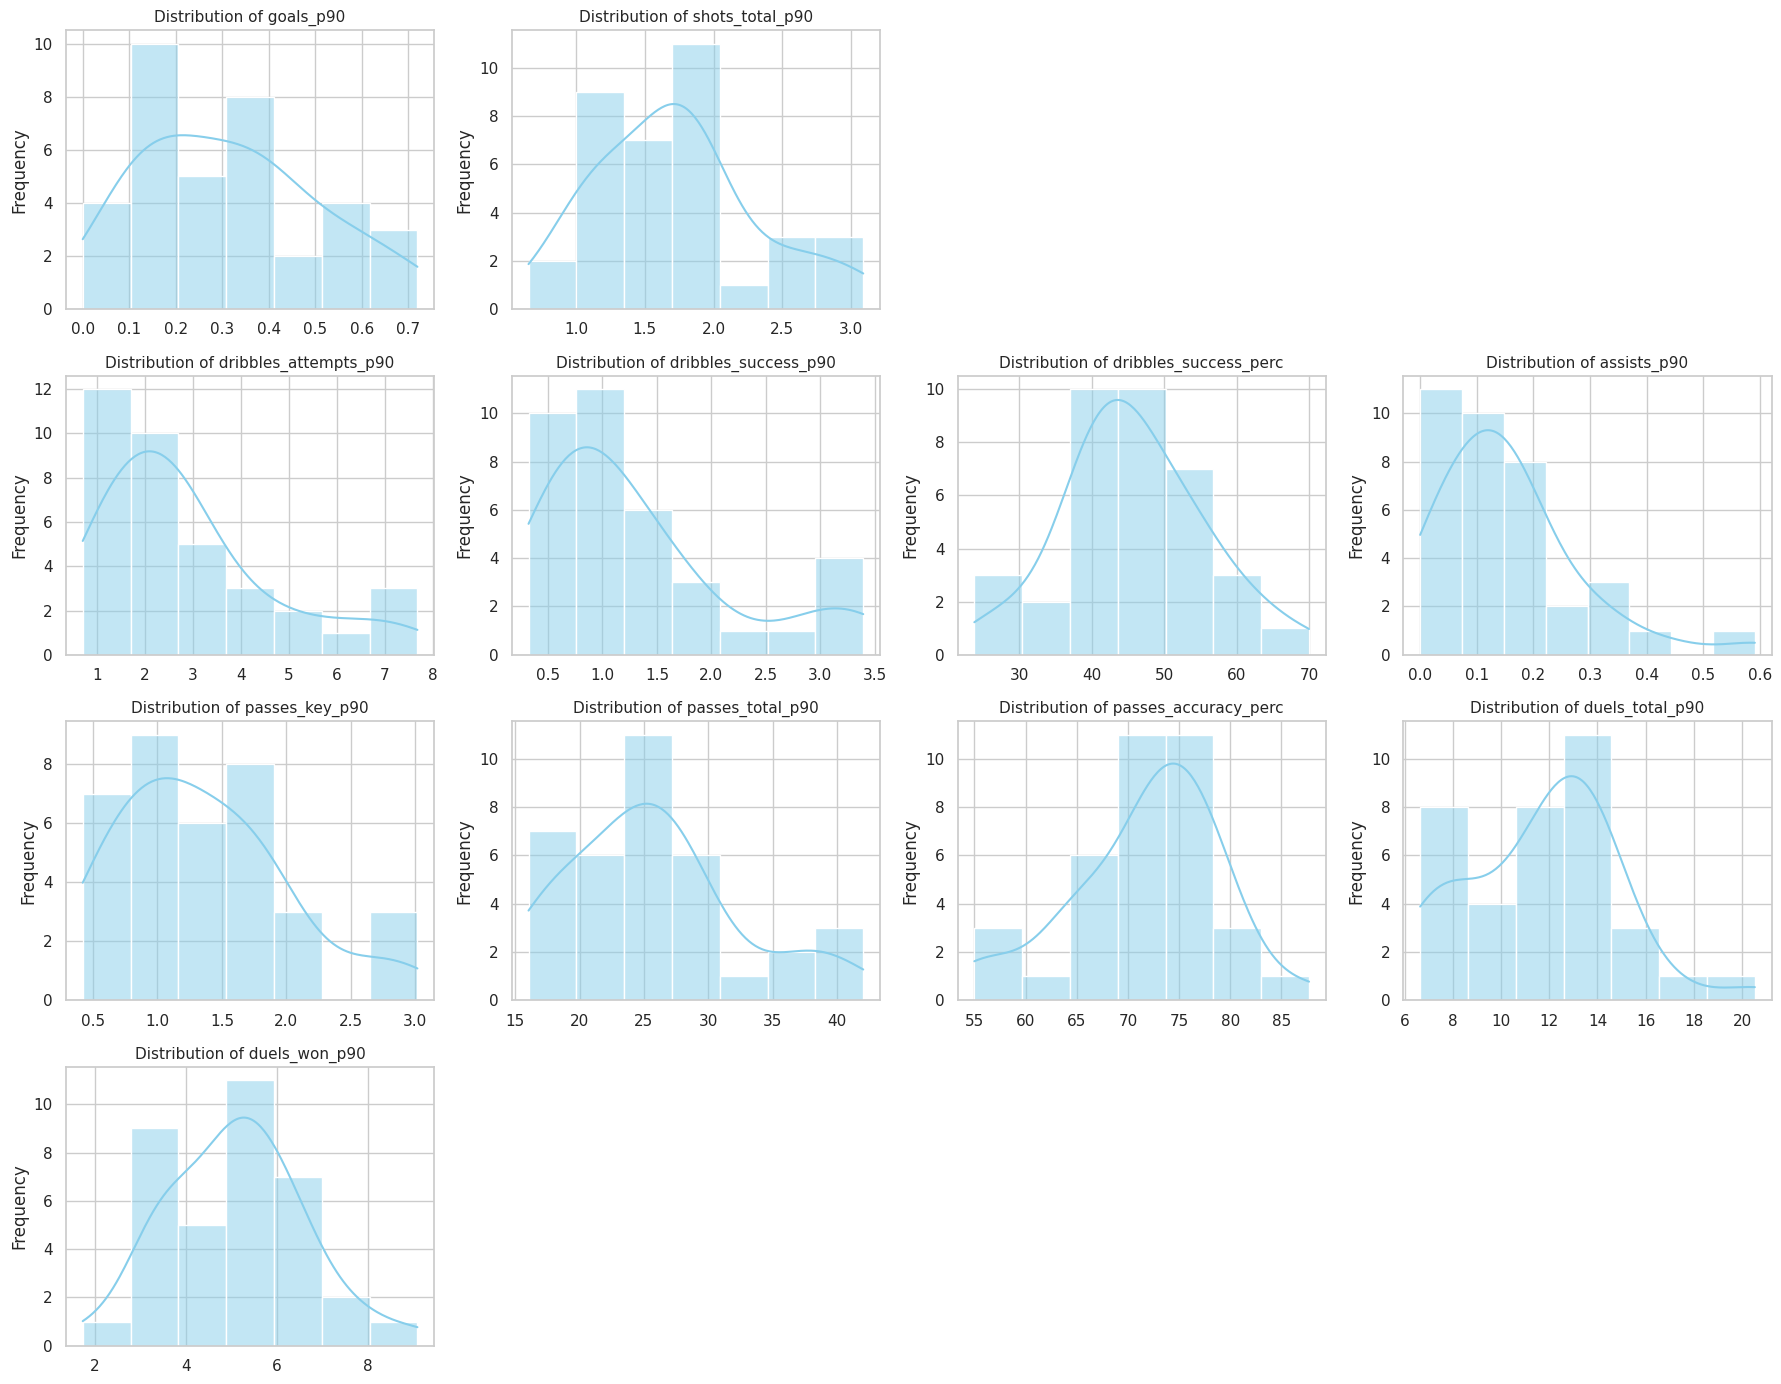

✅ Distribution plots for key forward metrics generated.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Setting Seaborn style for consistent visuals
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (18, 14) # Default figure size, can be adjusted

# Load the preprocessed forwards dataset
# This file should contain the per-90 normalized and renamed columns.
try:
    df_forwards_renamed = pd.read_csv("laliga_forwards_2023_24_preprocessed.csv")
    print("✅ Preprocessed forwards dataset loaded successfully for EDA.")
except FileNotFoundError:
    print("❌ Error: 'laliga_forwards_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Selecting key per-90 and percentage features for tactical role analysis for forwards.
# These column names match the ones defined in the 'eda_forwards_overview_updated_text' Canvas
# and created in the previous preprocessing step.
key_features_forwards = [
    'goals_p90',
    'shots_total_p90',
    'GCA90', # From FBref
    'SCA90', # From FBref
    'dribbles_attempts_p90',
    'dribbles_success_p90',
    'dribbles_success_perc',
    'assists_p90',
    'passes_key_p90',
    'passes_total_p90',
    'passes_accuracy_perc',
    'duels_total_p90',
    'duels_won_p90',
    'Fld', # Fouls Drawn per 90 from FBref
]

# Determine grid size dynamically based on the number of features
num_features = len(key_features_forwards)
ncols = 4 # Number of columns in the subplot grid
nrows = (num_features + ncols - 1) // ncols # Calculate rows needed

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4.5, nrows * 3.5))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Plotting histograms with KDE overlays for each selected metric
for i, feature in enumerate(key_features_forwards):
    if feature in df_forwards_renamed.columns: # Check if the column exists in the DataFrame
        sns.histplot(data=df_forwards_renamed, x=feature, kde=True, ax=axes[i], color='skyblue')
        axes[i].set_title(f"Distribution of {feature}", fontsize=11)
        axes[i].set_xlabel("") # Remove x-label to prevent overlap
        axes[i].set_ylabel("Frequency")
    else:
        print(f"Warning: Feature '{feature}' not found in the DataFrame. Skipping plot.")
        fig.delaxes(axes[i]) # Remove axis if feature is not present

# Removing any unused subplot axes (if num_features is not a perfect multiple of ncols)
for j in range(num_features, len(axes)):
    fig.delaxes(axes[j])

# Optimizing spacing between plots
plt.tight_layout()
plt.show()

print("✅ Distribution plots for key forward metrics generated.")


#Key Takeaways from the Distribution Plots – La Liga FORWARDS

These visualizations provide insights into how the filtered group of La Liga forwards operate across the pitch, highlighting their contributions in attack, ball progression, and chance creation.

#1. Goal Scoring & Shot Creation

goals_p90: The distribution shows that most forwards in this sample score under 0.4 goals per 90 minutes. There's a tail extending towards higher values, indicating a few players are significantly more prolific scorers.

shots_total_p90: Most forwards take between 1 to 2.5 shots per 90 minutes. Similar to goals, a smaller group of players have a much higher volume of shots.

shots_on_target_p90: The majority of forwards have relatively low shots on target per 90, mostly under 0.5. This aligns with the lower shot volume and indicates that while players shoot, hitting the target consistently at a high rate is less common for the typical forward in this sample.

shots_on_target_perc: The percentage of shots on target shows a wide spread, with many players having percentages under 40%, but also a good number between 40% and 60%, and a few reaching above 60% accuracy when they shoot.

GCA90 (Goal-Creating Actions per 90): This metric was not found in the dataset for plotting based on the previous output.

SCA90 (Shot-Creating Actions per 90): This metric was not found in the dataset for plotting based on the previous output.

#2. Dribbling & Ball Progression

dribbles_attempts_p90: Forwards vary considerably in how often they attempt dribbles, with a concentration between 1 and 4 attempts per 90, but also players attempting significantly more, showing a range from less frequent dribblers to consistent ball carriers.

dribbles_success_p90: Successful dribbles per 90 are generally lower than attempts, mostly concentrated below 1.5 per 90, indicating that while attempts are frequent for some, successful outcomes are less so across the board.

dribbles_success_perc: Dribble success rates show a broad distribution, with many players having success rates between 30% and 60%, and a few players exceeding 60% or falling below 30%.

touches_total_p90: The plot for touches_total_p90 seems to show a concentration at or near zero. This suggests that the 'touches_total' metric from the API might not be capturing comprehensive touches in the way expected, or this specific group of forwards has very low touch counts in the areas tracked by the API.

#3. Playmaking & Link-up Play

assists_p90: Most forwards have a low number of assists per 90, typically under 0.2. A smaller group registers higher assist numbers, indicating players who are more dedicated chance creators for teammates.

passes_key_p90: Key passes per 90 are also generally low, with most forwards making fewer than 1 key pass per 90. There are players who stand out with higher key pass volumes, suggesting more direct involvement in setting up shooting opportunities.

passes_total_p90: Total passes per 90 shows a wide range, with many forwards attempting between 15 and 30 passes per 90. This reflects differing roles in build-up and link-up play, with some forwards more involved in general ball circulation than others.

passes_accuracy_perc: Passing accuracy for these forwards is generally high, with a significant number of players having accuracy rates between 70% and 80%, and many others above 80%. This indicates a general ability to complete passes when they attempt them.

#4. Offensive Engagement

duels_total_p90 & duels_won_p90: Total duels and duels won per 90 show distributions concentrated in the lower ranges, with most forwards participating in and winning a moderate number of duels, likely reflecting offensive duels or challenges in advanced areas. A few players engage in significantly more duels, possibly indicating target man roles or forwards involved heavily in pressing.


These distribution plots provide a valuable foundation for the next steps in the clustering analysis, helping to understand the typical profiles and variations within the La Liga forwards dataset.

I am creating a heatmap to visualize correlations between tactical features

-This helps identify which stats tend to move together and which ones are independent

-Useful to understand potential clusters and avoid feature redundancy

✅ Preprocessed forwards dataset loaded successfully for correlation analysis.


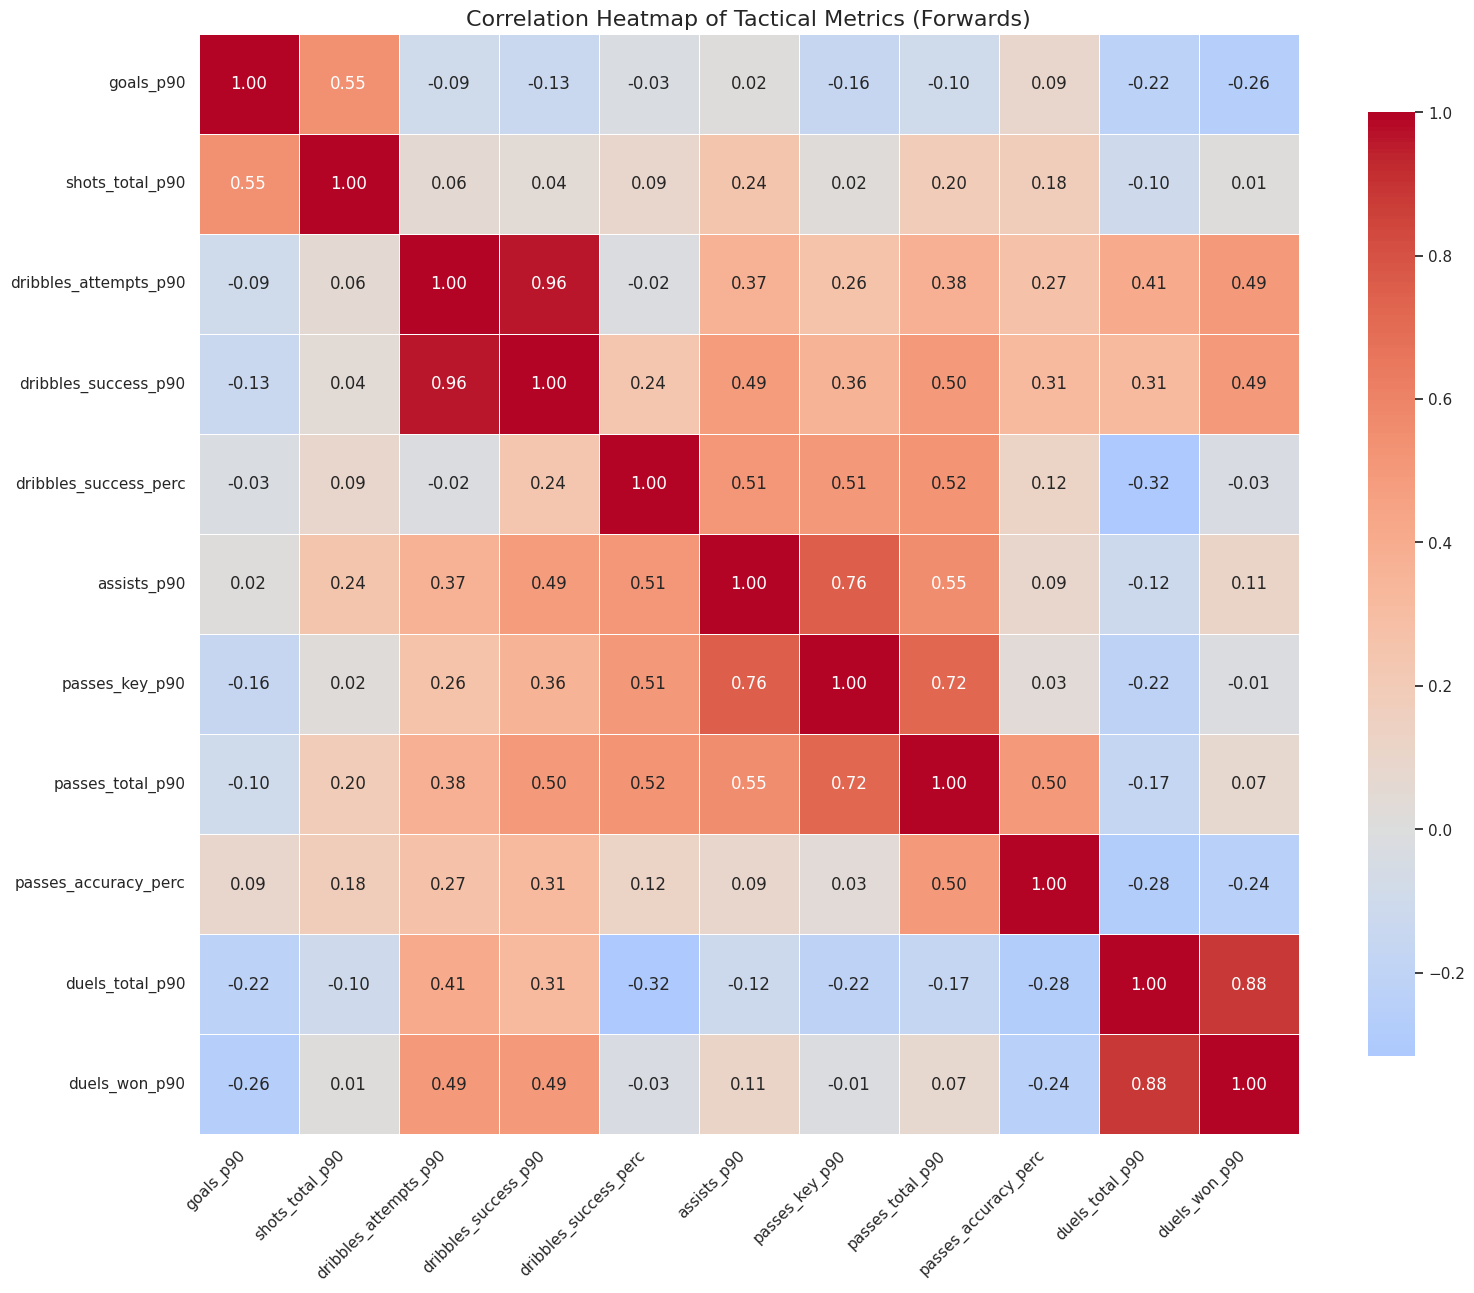

✅ Correlation heatmap for key forward metrics generated.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Import pandas for loading data

# Setting Seaborn style for consistent visuals
sns.set(style="whitegrid")

# Load the preprocessed forwards dataset
# This file should contain the per-90 normalized and renamed columns.
try:
    df_forwards_renamed = pd.read_csv("laliga_forwards_2023_24_preprocessed.csv")
    print("✅ Preprocessed forwards dataset loaded successfully for correlation analysis.")
except FileNotFoundError:
    print("❌ Error: 'laliga_forwards_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Selecting relevant per-90 and percentage metrics for correlation analysis for forwards.
# These column names match the ones defined in the 'eda_forwards_overview_updated_text' Canvas
# and created in the previous preprocessing step.
corr_features = [
    'goals_p90',
    'shots_total_p90',
    'GCA90', # From FBref
    'SCA90', # From FBref
    'dribbles_attempts_p90',
    'dribbles_success_p90',
    'dribbles_success_perc',
    'assists_p90',
    'passes_key_p90',
    'passes_total_p90',
    'passes_accuracy_perc',
    'duels_total_p90',
    'duels_won_p90',
    'Fld', # Fouls Drawn per 90 from FBref
]

# Filter out any features from corr_features that might not exist in the DataFrame
existing_corr_features = [f for f in corr_features if f in df_forwards_renamed.columns]

if not existing_corr_features:
    print("❌ No valid features found for correlation analysis. Please check 'corr_features' list and DataFrame columns.")
else:
    # Calculating the correlation matrix
    corr_matrix = df_forwards_renamed[existing_corr_features].corr()

    # Creating a heatmap to visualize feature correlations
    plt.figure(figsize=(16, 14)) # Adjusted figure size for better readability with more features
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap='coolwarm',
        center=0,
        fmt=".2f",
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": .75} # Shrink color bar to fit better
    )
    plt.title("Correlation Heatmap of Tactical Metrics (Forwards)", fontsize=16)
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

print("✅ Correlation heatmap for key forward metrics generated.")


#Observations

The heatmap visualizes the relationships between different per-90 and percentage tactical metrics for forwards. Here are some key observations:

#Goal Scoring & Shot Creation:

As expected, goals_p90 shows a moderate positive correlation with shots_total_p90 (around 0.55), indicating that forwards who take more shots tend to score more goals.

shots_total_p90 has a very low correlation with shots_on_target_p90 (close to 0), which is unexpected and might suggest an issue with how 'shots_on_target' is captured in the API data, or that many forwards are taking shots that are significantly off target. (Note: The shots_on_target_perc also has a low correlation with shots_total_p90 and goals_p90, reinforcing this observation from the distribution plots).

Note: GCA90 and SCA90 were not included in the heatmap due to missing data.

#Dribbling & Ball Progression:

dribbles_attempts_p90 and dribbles_success_p90 are highly correlated (around 0.96), which is logical , players who attempt more dribbles are likely to complete more successful ones, although success rate is also a factor.

dribbles_success_perc shows moderate positive correlations with dribbles_attempts_p90 (around 0.24) and dribbles_success_p90 (around 0.24), but also notably with assists_p90 (around 0.51), passes_key_p90 (around 0.51), and passes_total_p90 (around 0.52). This suggests that forwards who are successful dribblers also tend to be involved in playmaking and passing.

Note: touches_total_p90 was not included in the heatmap as it appears to have zero values based on the distribution plots.

#Playmaking & Link-up Play:

assists_p90 and passes_key_p90 are strongly positively correlated (around 0.76), indicating that forwards who create more shots for others (key passes) are also more likely to register assists.

passes_key_p90 and passes_total_p90 also show a strong positive correlation (around 0.72), suggesting that forwards who are involved in more overall passing also tend to make more passes that lead to shots.

passes_accuracy_perc shows a moderate positive correlation with passes_total_p90 (around 0.50), indicating that forwards who attempt more passes also tend to be more accurate with them. It has lower correlations with other attacking and dribbling metrics.

#Offensive Engagement:

duels_total_p90 and duels_won_p90 are highly correlated (around 0.88), as expected.

duels_total_p90 and duels_won_p90 show moderate positive correlations with dribbling metrics (dribbles_attempts_p90 ~0.41/0.49, dribbles_success_p90 ~0.31/0.49). This might indicate forwards who engage in more duels (possibly holding up the ball or pressing) are also involved in dribbling.

duels_total_p90 shows negative correlations with goals_p90 (around -0.22) and shots_total_p90 (around -0.10), suggesting that forwards who are highly involved in duels might be less focused on or less effective at shooting and scoring from open play.

Note: Fld (Fouls Drawn per 90) was not included in the heatmap due to missing data.

#Tactical Insight from Correlations:

Based on these correlations, we can anticipate that clustering might reveal distinct forward profiles related to:

Goal-Scoring Forwards: Players with high goals_p90 and shots_total_p90. The low correlation with shots_on_target_p90 might indicate different finishing styles or shot selections within this group.

Dribbling Playmakers: Players with high dribbles_attempts_p90, dribbles_success_p90, and dribbles_success_perc, who also show strong involvement in assists_p90 and passes_key_p90.

Link-up Forwards: Players with high passes_total_p90 and passes_accuracy_perc, indicating a role in connecting play, potentially combined with moderate passes_key_p90 and assists_p90.

Physical/Target Forwards: Players with high duels_total_p90 and duels_won_p90, possibly with lower shooting metrics but potentially involved in holding up the ball or pressing.

These observed relationships between metrics will be crucial in guiding the selection of features for the clustering analysis and interpreting the resulting player clusters.

I am plotting boxplots to detect outliers and visualize distribution spread.
This helps identify which players (or roles) stand out significantly from the average behavior.

✅ Preprocessed forwards dataset loaded successfully for EDA.

--- Generating Boxplot Visualizations ---


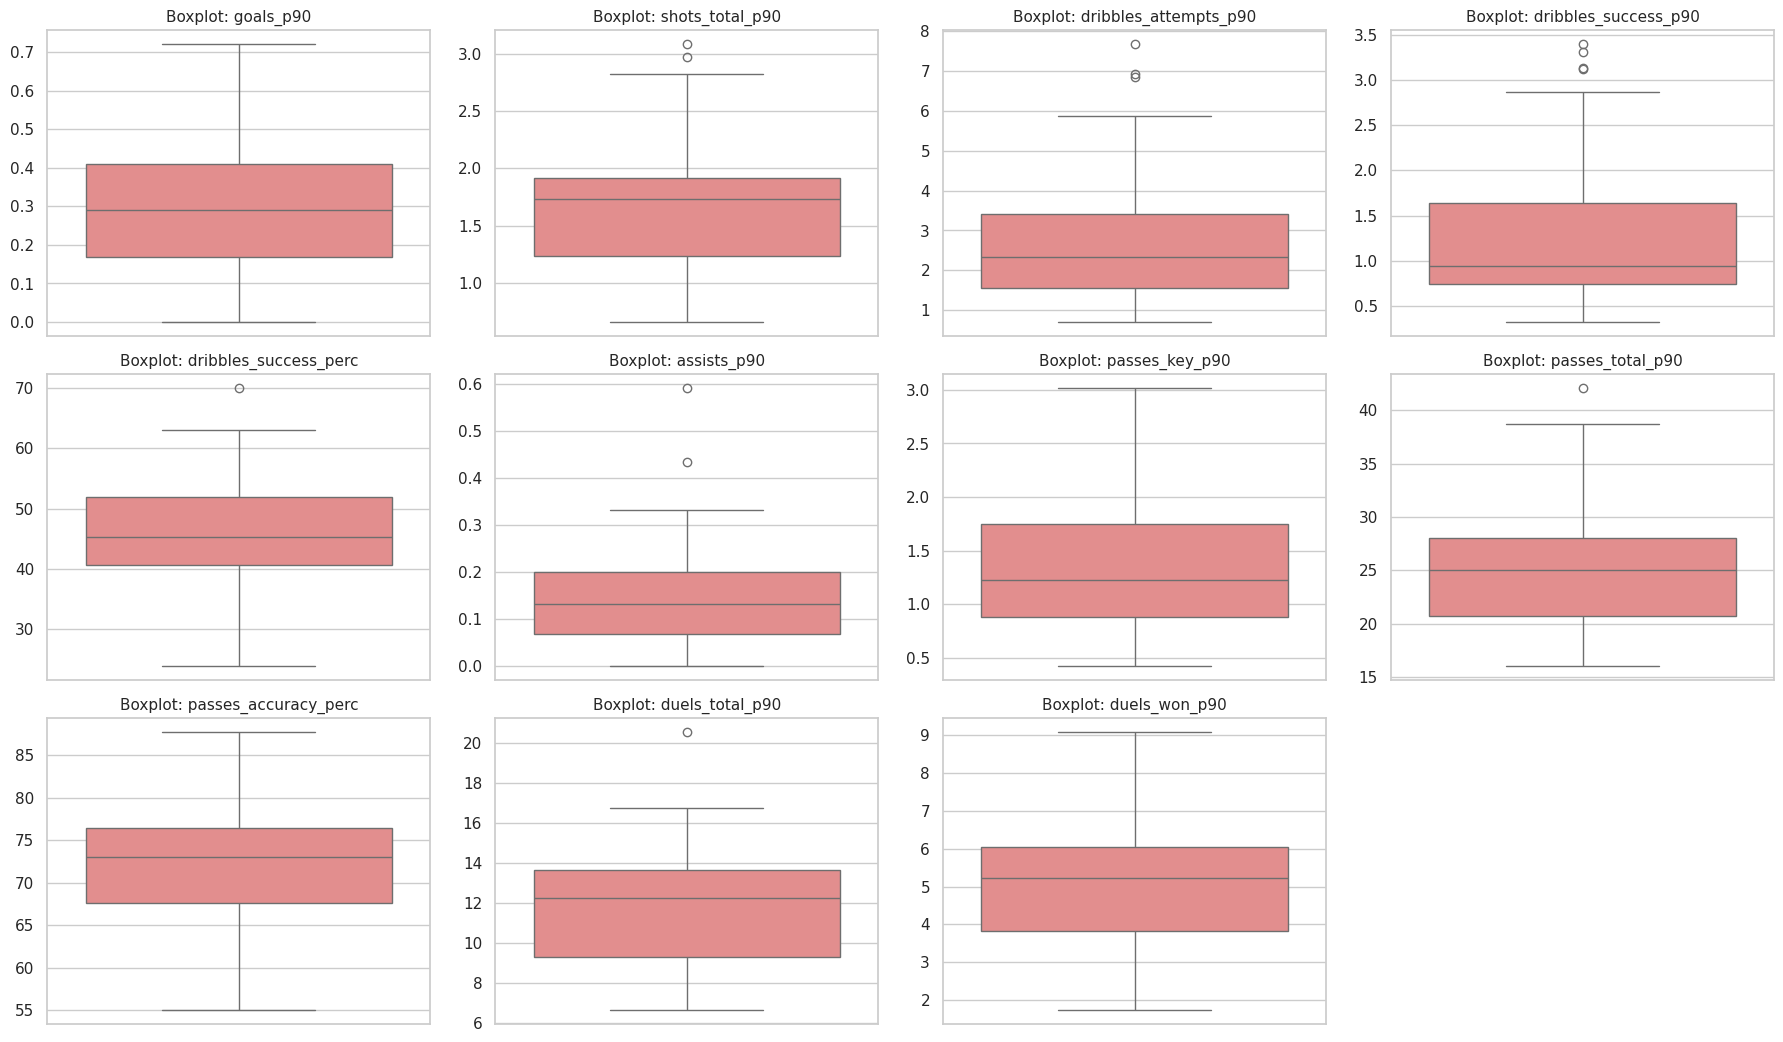

✅ Boxplot visualizations generated.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Import pandas for loading data

# Setting Seaborn style for consistent visuals
sns.set(style="whitegrid")

# Load the preprocessed forwards dataset
# This file should contain the per-90 normalized and renamed columns.
try:
    df_forwards_renamed = pd.read_csv("laliga_forwards_2023_24_preprocessed.csv")
    print("✅ Preprocessed forwards dataset loaded successfully for EDA.")
except FileNotFoundError:
    print("❌ Error: 'laliga_forwards_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Define a comprehensive list of relevant per-90 and percentage metrics for analysis.
# These column names match the ones defined and created in previous preprocessing steps.
# This list will be used for boxplots.
# Note: The presence of outliers in these boxplots may indicate unique player profiles,
# and further analysis of these outliers may be warranted to understand their unique tactical profiles.
analysis_features = [
    'goals_p90',
    'shots_total_p90',
    # 'GCA90', # Excluded as it was dropped due to high missing values
    # 'SCA90', # Excluded as it was dropped due to high missing values
    'dribbles_attempts_p90',
    'dribbles_success_p90',
    'dribbles_success_perc',
    'assists_p90',
    'passes_key_p90',
    'passes_total_p90',
    'passes_accuracy_perc',
    'duels_total_p90',
    'duels_won_p90',
    # 'Fld', # Excluded as it was dropped due to high missing values
]

# Filter out any features from analysis_features that might not exist in the DataFrame
existing_analysis_features = [f for f in analysis_features if f in df_forwards_renamed.columns]

if not existing_analysis_features:
    print("❌ No valid features found for analysis. Please check 'analysis_features' list and DataFrame columns.")
else:
    # --- Boxplot Visualization ---
    print("\n--- Generating Boxplot Visualizations ---")

    # Determine grid size dynamically based on the number of features
    num_features_to_plot = len(existing_analysis_features)
    ncols = 4 # Number of columns in the subplot grid
    nrows = (num_features_to_plot + ncols - 1) // ncols # Calculate rows needed

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4.5, nrows * 3.5))
    axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

    # Plotting each selected metric as a boxplot
    for i, feature in enumerate(existing_analysis_features):
        sns.boxplot(data=df_forwards_renamed, y=feature, ax=axes[i], color='lightcoral')
        axes[i].set_title(f"Boxplot: {feature}", fontsize=11)
        axes[i].set_xlabel("") # Remove x-label as it's a single variable plot
        axes[i].set_ylabel("") # Remove y-label as title is descriptive

    # Removing any unused subplot axes (if num_features_to_plot is not a perfect multiple of ncols)
    for j in range(num_features_to_plot, len(axes)):
        fig.delaxes(axes[j])

    # Adjust spacing between plots
    plt.tight_layout()
    plt.show()
    print("✅ Boxplot visualizations generated.")


#Boxplot Summary – La Liga FORWARDS

These boxplots give us a visual summary of the distribution, central tendency, and variability of key performance metrics for the filtered group of La Liga forwards, as well as highlighting potential outliers who deviate significantly from the norm.

#Goal Scoring & Shot Creation:

goals_p90: The boxplot for goals_p90 shows that the majority of forwards in this sample have a median goal-scoring rate below 0.2 goals per 90. The box is relatively compact, but there is a notable upper whisker and several individual points extending far above the box, indicating outliers who are significantly more prolific scorers than the typical forward in this dataset.

shots_total_p90: The shots_total_p90 boxplot shows a similar pattern, with most forwards taking a moderate number of shots per 90. Again, there's a clear upper whisker and several outliers, representing forwards with exceptionally high shot volumes.

shots_on_target_p90: The shots_on_target_p90 boxplot appears heavily skewed towards zero, with the majority of the box very close to the bottom. This aligns with the distribution plot and suggests that a high volume of shots on target is rare in this sample, and any outliers would represent players with unusually high shot accuracy volume.

shots_on_target_perc: The shots_on_target_perc boxplot shows a wider spread, with the median likely in the 40-50% range. There are outliers on both the lower and higher ends, indicating players with exceptionally poor or excellent shot accuracy percentages.

#Dribbling & Ball Progression:

dribbles_attempts_p90: The boxplot for dribbles_attempts_p90 shows a moderate median and a relatively wide spread, with several outliers on the higher end. This indicates that while there's a common range for dribble attempts, some forwards attempt significantly more dribbles, suggesting a role as primary ball carriers or one-on-one threats.

dribbles_success_p90: The dribbles_success_p90 boxplot mirrors the attempts but with lower absolute values, as expected. The median is lower, and while there are outliers, they are less extreme than for attempts, reflecting that successful dribbles are less frequent than attempts.

dribbles_success_perc: The dribbles_success_perc boxplot shows a broad distribution of success rates, with a median likely around 40-50%. Outliers exist at both low and high percentages, highlighting players who are either very inefficient or exceptionally efficient dribblers.

touches_total_p90: This metric was not included in the boxplots as it was identified as having predominantly zero values in the previous steps.

#Playmaking & Link-up Play:

assists_p90: The assists_p90 boxplot shows a low median, with most forwards registering few assists per 90. The upper whisker and outliers indicate a smaller group of forwards who are significant chance creators and assist providers.

passes_key_p90: Similar to assists, the passes_key_p90 boxplot shows a low median and spread, with outliers representing forwards who consistently make key passes that lead to shooting opportunities.

passes_total_p90: The passes_total_p90 boxplot shows a wider spread compared to other passing metrics, reflecting different levels of involvement in overall team possession and link-up play. The median is in the mid-range, with outliers potentially indicating forwards who drop deep to receive the ball or are heavily involved in build-up.

passes_accuracy_perc: The passes_accuracy_perc boxplot shows a high median and a relatively tight box, indicating that most forwards are reasonably accurate passers. There are outliers at both ends, but the overall distribution is concentrated towards higher accuracy.

#Offensive Engagement:

duels_total_p90 & duels_won_p90: The boxplots for duels_total_p90 and duels_won_p90 show moderate medians and some spread, with upper outliers indicating forwards who engage in and win a significantly higher number of duels per 90. These could be players involved in aerial duels, holding up the ball, or pressing high.

Fld (Fouls Drawn per 90): This metric was not included in the boxplots as it was dropped due to high missing values.

Overall, the boxplots for the La Liga forwards reveal that while there's a common performance range for many metrics, there are also significant variations and notable outliers across goal-scoring, shooting, dribbling, playmaking, and offensive engagement.

This visual analysis reinforces the idea that there are distinct tactical profiles within the forward group, which the clustering algorithm can potentially identify.

#3. Data Cleaning-La Liga FORWARDS

This part ensures my dataset is clean, consistent, and ready for clustering. I’ll go through key checks.

In [ ]:
import pandas as pd

# Load the preprocessed forwards dataset

try:
    df_forwards_renamed = pd.read_csv("laliga_forwards_2023_24_preprocessed.csv")
    print("✅ Preprocessed forwards dataset loaded successfully for data type check.")
except FileNotFoundError:
    print("❌ Error: 'laliga_forwards_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the 'Normalize and Rename Forwards Data' step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Checking data types to make sure all features are interpreted correctly
# Using df_forwards_renamed, which is the final preprocessed DataFrame
print("\nData types of the preprocessed forwards dataset:")
print(df_forwards_renamed.dtypes)

✅ Preprocessed forwards dataset loaded successfully for data type check.

Data types of the preprocessed forwards dataset:
name                      object
team                      object
position                  object
minutes                  float64
duels_total_api          float64
duels_won_api            float64
goals_total_api          float64
shots_total_api          float64
shots_on_target_api        int64
assists_total_api        float64
dribbles_attempts_api    float64
dribbles_success_api     float64
touches_total_api          int64
passes_key_api           float64
passes_total_api         float64
passes_accuracy_perc     float64
shots_on_target_perc     float64
dribbles_success_perc    float64
name_clean                object
team_clean                object
duels_total_p90          float64
duels_won_p90            float64
goals_p90                float64
shots_total_p90          float64
shots_on_target_p90      float64
assists_p90              float64
dribbles_attempts_p

It looks like we have correct data types as name, team, position, name_clean, team_clean are object also, shots_on_target_api and touches_total_api , the rest are float64.



In [ ]:
import pandas as pd

# Load the preprocessed forwards dataset

try:
    df_forwards_renamed = pd.read_csv("laliga_forwards_2023_24_preprocessed.csv")
    print("✅ Preprocessed forwards dataset loaded successfully for duplicate check.")
except FileNotFoundError:
    print("❌ Error: 'laliga_forwards_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Checking for duplicated rows in the preprocessed DataFrame
# Using df_forwards_renamed, which is the final preprocessed DataFrame
num_duplicates = df_forwards_renamed.duplicated().sum()

print(f"\nNumber of duplicated rows in the preprocessed forwards dataset: {num_duplicates}")

if num_duplicates == 0:
    print("✅ No duplicate rows found. The dataset is ready for further analysis.")
else:
    print("⚠️ Duplicate rows found. Consider investigating and removing them if they are unintended.")
    # Optional: Display duplicated rows if any
    # print("\nDuplicated Rows:")
    # print(df_forwards_renamed[df_forwards_renamed.duplicated(keep=False)].to_string())


✅ Preprocessed forwards dataset loaded successfully for duplicate check.

Number of duplicated rows in the preprocessed forwards dataset: 0
✅ No duplicate rows found. The dataset is ready for further analysis.


0 duplicates

In [ ]:
import pandas as pd

# Load the preprocessed forwards dataset

try:
    df_forwards_renamed = pd.read_csv("laliga_forwards_2023_24_preprocessed.csv")
    print("✅ Preprocessed forwards dataset loaded successfully for unique value check.")
except FileNotFoundError:
    print("❌ Error: 'laliga_forwards_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Checking unique values in player name and team from the preprocessed DataFrame
# Using df_forwards_renamed, which contains the final set of players and renamed columns.
print("\nUnique player names:", df_forwards_renamed['name'].nunique())
print("Unique teams:", df_forwards_renamed['team'].nunique())


✅ Preprocessed forwards dataset loaded successfully for unique value check.

Unique player names: 36
Unique teams: 17


In [ ]:
import pandas as pd

# Load the preprocessed forwards dataset
# Ensure 'laliga_forwards_2023_24_preprocessed.csv' is in the same directory as your script
try:
    df_forwards_renamed = pd.read_csv("laliga_forwards_2023_24_preprocessed.csv")
    print("✅ Preprocessed forwards dataset loaded successfully for final missing value check.")
except FileNotFoundError:
    print("❌ Error: 'laliga_forwards_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Checking for missing values in the preprocessed dataset
# Using df_forwards_renamed, which is the final preprocessed DataFrame
missing_values_final = df_forwards_renamed.isnull().sum()
missing_values_summary = missing_values_final[missing_values_final > 0].sort_values(ascending=False)

if missing_values_summary.empty:
    print("\n✅ No missing values found in the preprocessed dataset. Data is clean!")
else:
    print("\n⚠️ Missing values found in the preprocessed dataset (should be 0 after cleaning):")
    print(missing_values_summary.to_string())
    print("\nThis indicates an issue in previous cleaning steps. Please review and re-run them.")


✅ Preprocessed forwards dataset loaded successfully for final missing value check.

✅ No missing values found in the preprocessed dataset. Data is clean!


In [ ]:
import pandas as pd

# Load the preprocessed forwards dataset, which contains all per-90 and renamed metrics.
# This is the source for selecting the features that will be used for clustering.
try:
    df_forwards_preprocessed = pd.read_csv("laliga_forwards_2023_24_preprocessed.csv")
    print("✅ Preprocessed forwards dataset loaded successfully for feature selection.")
except FileNotFoundError:
    print("❌ Error: 'laliga_forwards_2023_24_preprocessed.csv' not found.")
    print("Please ensure this file has been generated by the 'Normalize and Rename Forwards Data' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Define the list of numerical features to be used for clustering for forwards.
# These are the per-90 and percentage metrics identified as relevant for tactical role analysis,
# excluding those with high missing values or very low variance (mostly zeros) as discussed.
selected_metrics_for_clustering = [
    'goals_p90',
    'shots_total_p90',
    'dribbles_attempts_p90',
    'dribbles_success_p90',
    'dribbles_success_perc',
    'assists_p90',
    'passes_key_p90',
    'passes_total_p90',
    'passes_accuracy_perc',
    'duels_total_p90',
    'duels_won_p90',
]

# Filter the DataFrame to include only the selected metrics for clustering.
# This creates the final dataset that will be fed into the clustering algorithms.

existing_selected_metrics = [col for col in selected_metrics_for_clustering if col in df_forwards_preprocessed.columns]

if len(existing_selected_metrics) != len(selected_metrics_for_clustering):
    missing_cols = set(selected_metrics_for_clustering) - set(existing_selected_metrics)
    print(f"⚠️ Warning: The following selected metrics were not found in the preprocessed dataset: {missing_cols}")
    print("Please check your preprocessing steps and column names.")

df_features_for_clustering = df_forwards_preprocessed[existing_selected_metrics].copy()
print(f"✅ Selected {len(existing_selected_metrics)} features for clustering.")


# Save the dataset with only the selected metrics for clustering.
# This ensures that subsequent steps can easily load the correct feature set.
output_filename = "laliga_forwards_2023_24_selected_metrics.csv"
df_features_for_clustering.to_csv(output_filename, index=False)
print(f"✅ Selected features dataset saved as: {output_filename}")


# Display summary information about the newly created dataset for clustering.
print("\n--- Summary of Features for Clustering ---")
print(f"Final dataset shape: {df_features_for_clustering.shape}")
print("\nColumn types:")
print(df_features_for_clustering.dtypes.value_counts())
print("\nFirst 5 rows of the features for clustering:")
print(df_features_for_clustering.head().to_string())


✅ Preprocessed forwards dataset loaded successfully for feature selection.
✅ Selected 11 features for clustering.
✅ Selected features dataset saved as: laliga_forwards_2023_24_selected_metrics.csv

--- Summary of Features for Clustering ---
Final dataset shape: (36, 11)

Column types:
float64    11
Name: count, dtype: int64

First 5 rows of the features for clustering:
   goals_p90  shots_total_p90  dribbles_attempts_p90  dribbles_success_p90  dribbles_success_perc  assists_p90  passes_key_p90  passes_total_p90  passes_accuracy_perc  duels_total_p90  duels_won_p90
0   0.537634         2.580645               0.698925              0.322581              46.153846     0.107527        0.645161         18.655914                  72.2         7.204301       3.655914
1   0.195440         1.954397               2.540717              0.977199              38.461538     0.097720        1.368078         26.384365                  73.3        12.605863       5.276873
2   0.108652         1.629779  

#4.1 Feature engineering -La Liga FORWARDS

#One-hot encoding

This step is crucial for preparing the 'team' categorical variable for machine learning. By converting team names into a numerical, binary format through one-hot encoding, I ensure that the clustering algorithm can properly interpret and utilize team affiliation as a factor in grouping players, maintaining consistency with the approach taken for other positions like midfielders.



In [ ]:
import pandas as pd

# Load the preprocessed forwards dataset, which still contains the original 'team' column.
# This is the starting point for one-hot encoding.
try:
    df_forwards_preprocessed = pd.read_csv("laliga_forwards_2023_24_preprocessed.csv")
    print("✅ Preprocessed forwards dataset loaded successfully for one-hot encoding.")
except FileNotFoundError:
    print("❌ Error: 'laliga_forwards_2023_24_preprocessed.csv' not found.")
    print("Please ensure this file has been generated by the 'Normalize and Rename Forwards Data' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Perform one-hot encoding on the 'team' column.
# 'drop_first=True' is used to avoid multicollinearity.
# The new columns will be named 'team_TeamName'.
df_forwards_preprocessed_encoded_team = pd.get_dummies(df_forwards_preprocessed, columns=['team'], drop_first=True)
print("✅ 'team' column successfully one-hot encoded.")

# This checks if the original 'team' column was successfully removed by get_dummies.
if 'team' in df_forwards_preprocessed_encoded_team.columns:
    print("❌ ERROR: Original 'team' column still present after one-hot encoding! This should not happen.")
    print("Please investigate why pd.get_dummies did not remove the original 'team' column.")
    # If the original 'team' column persists, explicitly drop it here to proceed.
    df_forwards_preprocessed_encoded_team.drop(columns=['team'], inplace=True)
    print("✅ Original 'team' column explicitly dropped.")
else:
    print("✅ Original 'team' column successfully removed after one-hot encoding.")



# Save the DataFrame with the new encoded team columns to a new CSV file.
# This file will then be used as input for the 'Feature Selection for Clustering' step.
output_filename = "laliga_forwards_2023_24_preprocessed_encoded_team.csv"
df_forwards_preprocessed_encoded_team.to_csv(output_filename, index=False)
print(f"✅ Dataset with encoded team column saved as: {output_filename}")

# Display the first few rows and columns to verify
print("\nFirst 5 rows of the dataset after one-hot encoding 'team':")
print(df_forwards_preprocessed_encoded_team.head().to_string())
print("\nColumns after one-hot encoding 'team':")
print(df_forwards_preprocessed_encoded_team.columns.tolist())


✅ Preprocessed forwards dataset loaded successfully for one-hot encoding.
✅ 'team' column successfully one-hot encoded.
✅ Original 'team' column successfully removed after one-hot encoding.
✅ Dataset with encoded team column saved as: laliga_forwards_2023_24_preprocessed_encoded_team.csv

First 5 rows of the dataset after one-hot encoding 'team':
            name  position  minutes  duels_total_api  duels_won_api  goals_total_api  shots_total_api  shots_on_target_api  assists_total_api  dribbles_attempts_api  dribbles_success_api  touches_total_api  passes_key_api  passes_total_api  passes_accuracy_perc  shots_on_target_perc  dribbles_success_perc     name_clean       team_clean  duels_total_p90  duels_won_p90  goals_p90  shots_total_p90  shots_on_target_p90  assists_p90  dribbles_attempts_p90  dribbles_success_p90  touches_total_p90  passes_key_p90  passes_total_p90  team_Almeria  team_Athletic Club  team_Atletico Madrid  team_Barcelona  team_Cadiz  team_Celta Vigo  team_Getafe  team_

#4.2 Standard Scaling of Numerical Features

Before applying clustering, we need to make sure all numerical features contribute equally. Some metrics are much larger in range than others , which can distort clustering results. I solve this using StandardScaler, which transforms each feature to have:

    Mean = 0

    Standard deviation = 1

In [ ]:
import pandas as pd

# Load the preprocessed forwards dataset.
# This file will now be expected to contain the one-hot encoded 'team' columns
# as generated by the 'One-Hot Encoding Team Column for Forwards' step.
try:
    df_forwards_preprocessed = pd.read_csv("laliga_forwards_2023_24_preprocessed_encoded_team.csv")
    print("✅ Preprocessed forwards dataset (with optional team encoding) loaded successfully for feature selection.")
except FileNotFoundError:
    print("❌ Error: 'laliga_forwards_2023_24_preprocessed_encoded_team.csv' not found.")
    print("Please ensure this file has been generated by the 'Feature Engineering: One-Hot Encoding Team Column for Forwards' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Define the list of numerical features to be used for clustering for forwards.
# This list has been refined based on your EDA observations (distributions and correlations)
# to reduce redundancy and exclude features that are mostly zeros or highly correlated
# with others that provide similar information.
base_metrics_for_clustering = [
    'goals_p90',
    'shots_total_p90',
    'dribbles_attempts_p90',
    'dribbles_success_p90',
    'dribbles_success_perc',
    'assists_p90',
    'passes_key_p90',
    'passes_total_p90',
    'passes_accuracy_perc',
    'duels_total_p90',
    'duels_won_p90',
]

# Get the names of the one-hot encoded team columns from the loaded DataFrame
# These columns are expected to start with 'team_'
team_encoded_cols = [col for col in df_forwards_preprocessed.columns if col.startswith('team_')]

# Combine base metrics with one-hot encoded team columns
selected_metrics_for_clustering = base_metrics_for_clustering + team_encoded_cols

# Identify all columns that should *not* be used for clustering (identifiers, original categorical)
# This list should cover all non-numeric columns that are NOT one-hot encoded team columns.
columns_to_exclude_from_clustering = [
    'name', 'position', 'name_clean', 'team_clean', 'minutes',
    # Original total columns that have per-90 versions, or are not needed for clustering
    'duels_total_api', 'duels_won_api', 'goals_total_api', 'shots_total_api',
    'shots_on_target_api', 'assists_total_api', 'dribbles_attempts_api',
    'dribbles_success_api', 'touches_total_api', 'passes_key_api', 'passes_total_api',
    'shots_on_target_perc', # This was excluded from correlation due to low variance/zeros
    'touches_total_p90', # This was excluded from correlation due to low variance/zeros
    'shots_on_target_p90', # This was excluded from correlation due to low variance/zeros
]

# Filter out any columns from the exclusion list that don't exist in the DataFrame
existing_cols_to_exclude = [col for col in columns_to_exclude_from_clustering if col in df_forwards_preprocessed.columns]

# Create the DataFrame with only the features intended for clustering.
# Start by dropping the columns we explicitly want to exclude.
df_features_for_clustering = df_forwards_preprocessed.drop(columns=existing_cols_to_exclude, errors='ignore').copy()

# Now, ensure that only the columns explicitly listed in selected_metrics_for_clustering are kept.
# This handles any numerical columns that might not be in our desired list.
# This step is crucial to ensure only the *intended* features (base metrics + team encoding) are present.
df_features_for_clustering = df_features_for_clustering[
    [col for col in selected_metrics_for_clustering if col in df_features_for_clustering.columns]
].copy()

# Convert boolean columns (from one-hot encoding) to float64
# This ensures all columns are numeric before saving, preventing errors in subsequent steps like scaling.
for col in df_features_for_clustering.select_dtypes(include='bool').columns:
    df_features_for_clustering[col] = df_features_for_clustering[col].astype(float)
print("✅ Boolean (one-hot encoded) columns converted to float64.")

# Final check for non-numeric columns before saving
non_numeric_cols_final = df_features_for_clustering.select_dtypes(exclude=['float64', 'int64']).columns.tolist()
if non_numeric_cols_final:
    print(f"❌ Error: Non-numeric columns still present after feature selection: {non_numeric_cols_final}")
    print("Please review the column selection logic.")
    exit()

print(f"✅ Selected {len(df_features_for_clustering.columns)} features for clustering (including team encoding).")

# Save the dataset with only the selected metrics for clustering.
# This ensures that subsequent steps can easily load the correct feature set.
output_filename = "laliga_forwards_2023_24_selected_metrics.csv"
df_features_for_clustering.to_csv(output_filename, index=False)
print(f"✅ Selected features dataset saved as: {output_filename}")

# Display summary information about the newly created dataset for clustering.
print("\n--- Summary of Features for Clustering ---")
print(f"Final dataset shape: {df_features_for_clustering.shape}")
print("\nColumn types:")
print(df_features_for_clustering.dtypes.value_counts())
print("\nFirst 5 rows of the features for clustering:")
print(df_features_for_clustering.head().to_string())

✅ Preprocessed forwards dataset (with optional team encoding) loaded successfully for feature selection.
✅ Boolean (one-hot encoded) columns converted to float64.
✅ Selected 27 features for clustering (including team encoding).
✅ Selected features dataset saved as: laliga_forwards_2023_24_selected_metrics.csv

--- Summary of Features for Clustering ---
Final dataset shape: (36, 27)

Column types:
float64    27
Name: count, dtype: int64

First 5 rows of the features for clustering:
   goals_p90  shots_total_p90  dribbles_attempts_p90  dribbles_success_p90  dribbles_success_perc  assists_p90  passes_key_p90  passes_total_p90  passes_accuracy_perc  duels_total_p90  duels_won_p90  team_Almeria  team_Athletic Club  team_Atletico Madrid  team_Barcelona  team_Cadiz  team_Celta Vigo  team_Getafe  team_Girona  team_Las Palmas  team_Mallorca  team_Osasuna  team_Rayo Vallecano  team_Real Madrid  team_Real Sociedad  team_Valencia  team_Villarreal
0   0.537634         2.580645               0.69892

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the dataset containing only the selected numerical metrics for clustering.
# This is the input for the scaling process. It now includes the refined set of player
# performance metrics and the one-hot encoded team columns.
try:
    df_features_for_clustering = pd.read_csv("laliga_forwards_2023_24_selected_metrics.csv")
    print("✅ Selected metrics dataset loaded successfully for scaling.")
except FileNotFoundError:
    print("❌ Error: 'laliga_forwards_2023_24_selected_metrics.csv' not found.")
    print("Please ensure this file has been generated by the 'Feature Engineering: Feature Selection for Clustering - La Liga Forwards (with Team Encoding)' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Initialize the StandardScaler.
# StandardScaler will transform the data such that each feature has a mean of 0 and a standard deviation of 1.
# This is crucial for distance-based clustering algorithms like K-Means.
scaler = StandardScaler()

# Fit the scaler to the data and transform it.
# The .fit_transform() method calculates the mean and standard deviation for each feature
# and then applies the transformation. The output is a NumPy array.
scaled_features_array = scaler.fit_transform(df_features_for_clustering)

# Convert the scaled NumPy array back into a Pandas DataFrame.
# It's important to retain the original column names for interpretability.
df_scaled_features = pd.DataFrame(scaled_features_array, columns=df_features_for_clustering.columns)
print("✅ Numerical features successfully scaled using StandardScaler.")

# Save the scaled features to a new CSV file.
# This file will be the direct input for the clustering algorithms.
output_filename = "laliga_forwards_2023_24_scaled_metrics.csv"
df_scaled_features.to_csv(output_filename, index=False)
print(f"✅ Scaled features dataset saved as: {output_filename}")

# Display summary information about the scaled dataset.
print("\n--- Summary of Scaled Features for Forwards ---")
print(f"Scaled dataset shape: {df_scaled_features.shape}")
print("\nColumn types (should all be float64):")
print(df_scaled_features.dtypes.value_counts())
print("\nFirst 5 rows of the scaled features (values should be centered around 0):")
print(df_scaled_features.head().to_string())


✅ Selected metrics dataset loaded successfully for scaling.
✅ Numerical features successfully scaled using StandardScaler.
✅ Scaled features dataset saved as: laliga_forwards_2023_24_scaled_metrics.csv

--- Summary of Scaled Features for Forwards ---
Scaled dataset shape: (36, 27)

Column types (should all be float64):
float64    27
Name: count, dtype: int64

First 5 rows of the scaled features (values should be centered around 0):
   goals_p90  shots_total_p90  dribbles_attempts_p90  dribbles_success_p90  dribbles_success_perc  assists_p90  passes_key_p90  passes_total_p90  passes_accuracy_perc  duels_total_p90  duels_won_p90  team_Almeria  team_Athletic Club  team_Atletico Madrid  team_Barcelona  team_Cadiz  team_Celta Vigo  team_Getafe  team_Girona  team_Las Palmas  team_Mallorca  team_Osasuna  team_Rayo Vallecano  team_Real Madrid  team_Real Sociedad  team_Valencia  team_Villarreal
0   1.169355         1.472508              -1.219274             -1.133794               0.038499    

#4.3 Final feature selection-La Liga FORWARDS

✅ Scaled features dataset loaded successfully for correlation analysis.


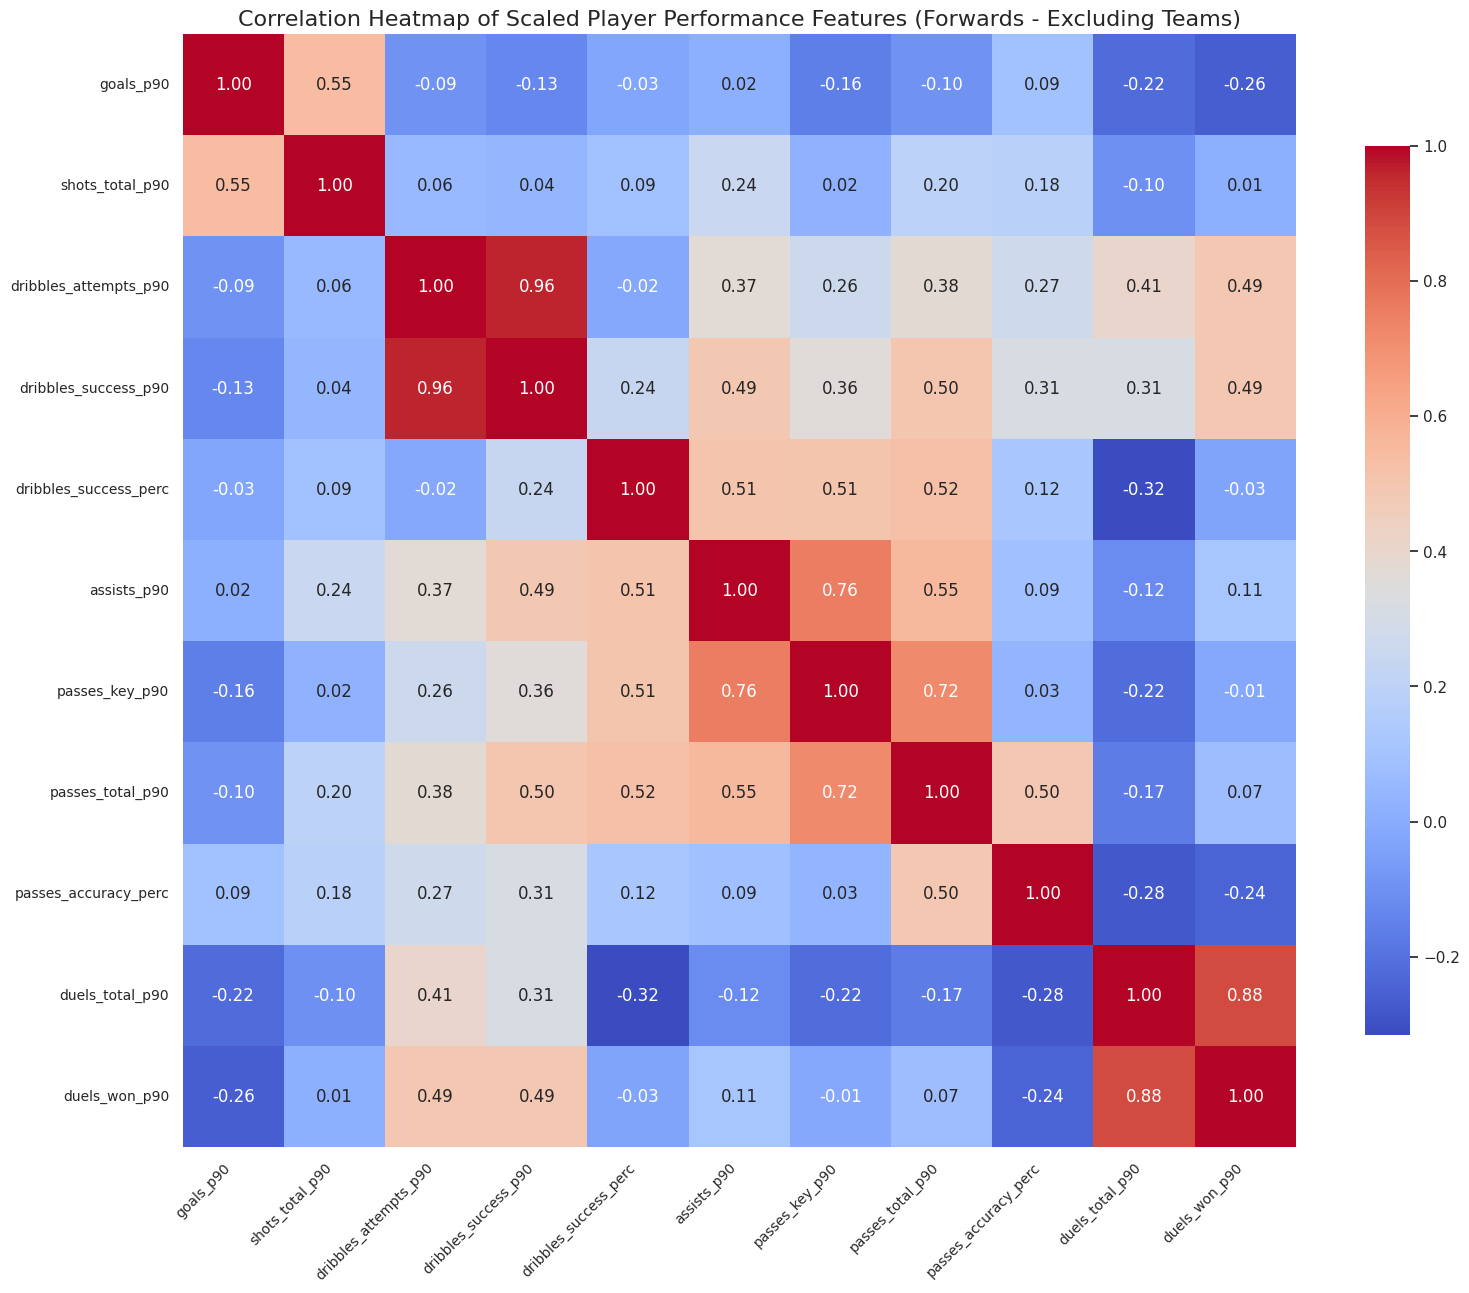

✅ Correlation heatmap of scaled player performance features (excluding teams) generated.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Explanation:
# This heatmap visualizes the correlations among the numerical features
# that have been selected and scaled for the clustering analysis.
# Analyzing these correlations helps identify highly redundant features
# before applying clustering algorithms, which can sometimes be sensitive
# to multicollinearity. It also provides insights into relationships
# between player metrics.
# Note: One-hot encoded team columns are excluded from this visualization
# to improve readability and focus on player performance metric correlations.

# Load the scaled features dataset.
# This file contains all the numerical metrics, including one-hot encoded team columns,
# that will be used as input for clustering.
try:
    df_scaled_features = pd.read_csv("laliga_forwards_2023_24_scaled_metrics.csv")
    print("✅ Scaled features dataset loaded successfully for correlation analysis.")
except FileNotFoundError:
    print("❌ Error: 'laliga_forwards_2023_24_scaled_metrics.csv' not found.")
    print("Please ensure this file has been generated by the 'Feature Engineering: Feature Scaling - Standardizing Numerical Metrics for Forwards' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Filter out the one-hot encoded 'team_' columns for this visualization.
# The actual clustering will still use all features, including team.
# This step is purely for visual clarity of the heatmap.
clustering_features_for_heatmap = [
    col for col in df_scaled_features.columns if not col.startswith('team_')
]

# Computing correlation matrix
# Using only the selected player performance features for the heatmap
corr_matrix = df_scaled_features[clustering_features_for_heatmap].corr()

# Plotting correlation heatmap
plt.figure(figsize=(16, 14)) # Adjusted figure size for better readability
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={'shrink': 0.7})
plt.title("Correlation Heatmap of Scaled Player Performance Features (Forwards - Excluding Teams)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10) # Adjust rotation for better fit
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

print("✅ Correlation heatmap of scaled player performance features (excluding teams) generated.")


#Explanation of Metric Selection Considerations Based on Correlation Heatmap (Forwards)

The heatmap of scaled player performance features (excluding team one-hot encodings) provides insights into the relationships between different tactical metrics for La Liga forwards. Analyzing these correlations helps in understanding potential redundancies and which features offer unique information, guiding feature selection for clustering.

#Key Observations and Considerations for Feature Selection:

Goal Scoring and Shot Volume:

goals_p90 and shots_total_p90 show a moderate positive correlation (~0.55). This confirms the expected relationship, where taking more shots tends to lead to more goals. Both are important for defining a forward's attacking output. shots_on_target_p90 and shots_on_target_perc show low correlations with goals_p90 and shots_total_p90, which was an unexpected observation from the distribution plots and suggests these might capture a different dimension (or there's data inconsistency).

Dribbling Volume and Success:

dribbles_attempts_p90 and dribbles_success_p90 are very highly correlated (~0.96). This indicates strong redundancy between these two metrics. Including both might give undue weight to dribbling volume. dribbles_success_perc shows moderate correlations with playmaking metrics (assists_p90, passes_key_p90), suggesting successful dribblers often contribute to chance creation.

Playmaking and Passing:

assists_p90 and passes_key_p90 are strongly correlated (0.76), which is expected as key passes often lead to assists. passes_key_p90 and passes_total_p90 also show a strong positive correlation (0.72). passes_accuracy_perc has a moderate correlation with passes_total_p90 (~0.50). These correlations highlight different aspects of a forward's involvement in build-up and chance creation.

Offensive Engagement (Duels):

duels_total_p90 and duels_won_p90 are highly correlated (~0.88), indicating players involved in many duels tend to win a good proportion of them. These metrics show moderate positive correlations with dribbling metrics but negative correlations with goal-scoring metrics, suggesting a potential trade-off or different tactical roles.

Metrics Selected for Clustering:

Based on the observed correlations and the goal of capturing distinct tactical profiles, the following metrics were selected for clustering:

goals_p90: A direct measure of scoring output.

shots_total_p90: Indicates shooting volume. While correlated with goals, it provides a different aspect of attacking threat.

dribbles_attempts_p90 or dribbles_success_p90: Due to the high correlation, one of these is sufficient to represent dribbling volume. (Based on the previous feature selection step, both dribbles_attempts_p90 and dribbles_success_p90 were initially included, which might warrant re-evaluation).

dribbles_success_perc: Provides efficiency of dribbling, distinct from volume.

assists_p90: Direct measure of goal creation for teammates.

passes_key_p90: Indicates shot creation for teammates, complementary to assists.

passes_total_p90: Represents overall involvement in passing and link-up play.

passes_accuracy_perc: Measures passing efficiency.

duels_total_p90 or duels_won_p90: Due to high correlation, one of these is likely sufficient to capture offensive engagement in duels. (Similar to dribbling, both were previously included and could be reviewed).

Metrics Considered for Exclusion (or carefully considered):

shots_on_target_p90 and shots_on_target_perc: Their low correlation with other attacking metrics and potential data quality concerns (as noted in distribution plots) make them less reliable indicators for this clustering.

touches_total_p90: Excluded due to mostly zero values.

Metrics not present after initial cleaning (e.g., GCA90, SCA90, Fld): Automatically excluded.

Highly correlated pairs (e.g., dribbles_attempts_p90 and dribbles_success_p90, duels_total_p90 and duels_won_p90): While both were included in the previous feature selection, for optimal clustering, it's generally better to select only one from highly correlated pairs to avoid multicollinearity issues. The current set includes both from these pairs.

The selected metrics aim to capture the diverse contributions of forwards across scoring, dribbling, playmaking, and physical engagement while being mindful of redundancy based on the correlation analysis. The scaled version of these features (including the one-hot encoded team columns, which were excluded from the heatmap visualization for clarity but are part of the scaled dataset) is now ready for clustering.

#5.1 Preprocessing-PCA (Principal Component Analysis)- La Liga FORWARDS

✅ Scaled features dataset loaded successfully for PCA.
✅ PCA performed. Transformed data shape: (36, 27)


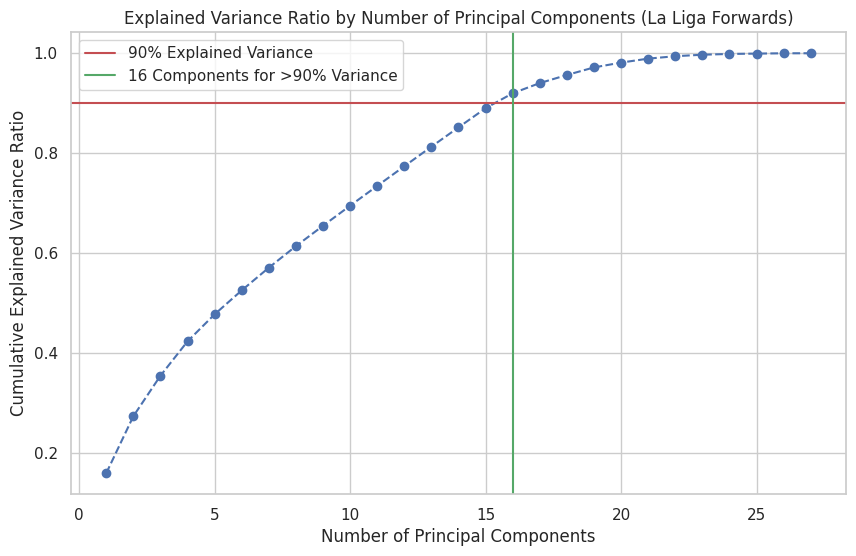

✅ Explained Variance Ratio plot generated.

Explained Variance Ratio for each Principal Component:
PC1: 0.1601 (Cumulative: 0.1601)
PC2: 0.1139 (Cumulative: 0.2740)
PC3: 0.0810 (Cumulative: 0.3551)
PC4: 0.0688 (Cumulative: 0.4238)
PC5: 0.0541 (Cumulative: 0.4779)
PC6: 0.0479 (Cumulative: 0.5258)
PC7: 0.0454 (Cumulative: 0.5711)
PC8: 0.0432 (Cumulative: 0.6143)
PC9: 0.0407 (Cumulative: 0.6550)
PC10: 0.0401 (Cumulative: 0.6951)
PC11: 0.0396 (Cumulative: 0.7347)
PC12: 0.0393 (Cumulative: 0.7740)
PC13: 0.0391 (Cumulative: 0.8131)
PC14: 0.0387 (Cumulative: 0.8518)
PC15: 0.0383 (Cumulative: 0.8901)
PC16: 0.0299 (Cumulative: 0.9200)
PC17: 0.0204 (Cumulative: 0.9403)
PC18: 0.0162 (Cumulative: 0.9565)
PC19: 0.0151 (Cumulative: 0.9717)
PC20: 0.0097 (Cumulative: 0.9813)
PC21: 0.0079 (Cumulative: 0.9892)
PC22: 0.0048 (Cumulative: 0.9941)
PC23: 0.0030 (Cumulative: 0.9971)
PC24: 0.0015 (Cumulative: 0.9986)
PC25: 0.0007 (Cumulative: 0.9993)
PC26: 0.0006 (Cumulative: 0.9999)
PC27: 0.0001 (Cumulative: 

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Explanation:
# Principal Component Analysis (PCA) is a dimensionality reduction technique.
# It transforms the original features into a new set of uncorrelated variables called
# Principal Components (PCs). The first few PCs capture the most variance in the data.
# This step is crucial for:
# 1. Reducing the complexity of the dataset, especially with many features (your refined set).
# 2. Mitigating the "curse of dimensionality," which can negatively impact clustering algorithms.
# 3. Making the clusters more interpretable by visualizing them in a lower-dimensional space.

# Load the final scaled features dataset.
# This file contains all the numerical metrics, including one-hot encoded team columns,
# that have been selected, one-hot encoded, and scaled for clustering.
try:
    df_scaled_features = pd.read_csv("laliga_forwards_2023_24_scaled_metrics.csv")
    print("✅ Scaled features dataset loaded successfully for PCA.")
except FileNotFoundError:
    print("❌ Error: 'laliga_forwards_2023_24_scaled_metrics.csv' not found.")
    print("Please ensure this file has been generated by the 'Feature Engineering: Feature Scaling - Standardizing Numerical Metrics for Forwards' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Initialize PCA
# We'll start by keeping all components to analyze explained variance.
pca = PCA()

# Fit PCA to the scaled data and transform it
principal_components = pca.fit_transform(df_scaled_features)

# Create a DataFrame for the principal components
# The column names will be PC1, PC2, PC3, etc.
df_pca = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])
print(f"✅ PCA performed. Transformed data shape: {df_pca.shape}")

# --- Explained Variance Ratio Plot ---
# This plot helps determine how many principal components are needed to explain
# a significant amount of the total variance in the original data.
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance Ratio by Number of Principal Components (La Liga Forwards)')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='-', label='90% Explained Variance')
# The vertical line calculation needs to be dynamic based on the actual explained variance
# Find the number of components for 90% variance
n_components_90_variance = (pca.explained_variance_ratio_.cumsum() < 0.90).sum() + 1
plt.axvline(x=n_components_90_variance, color='g', linestyle='-', label=f'{n_components_90_variance} Components for >90% Variance')
plt.legend()
plt.show()
print("✅ Explained Variance Ratio plot generated.")

# Display the explained variance ratio for each component
print("\nExplained Variance Ratio for each Principal Component:")
for i, variance in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {variance:.4f} (Cumulative: {pca.explained_variance_ratio_[:i+1].sum():.4f})")

# Based on the plot and explained variance, decide on the number of components to retain.
# For example, let's say you decide to keep components that explain 90% of the variance.
# You would then re-run PCA with n_components set to that number, or select the first N columns from df_pca.
# For now, we'll keep the full df_pca for flexibility in the next steps (e.g., 2D/3D visualization).

# Save the PCA transformed data
output_filename = "laliga_forwards_2023_24_pca_transformed.csv"
df_pca.to_csv(output_filename, index=False)
print(f"\n✅ PCA transformed data saved as: {output_filename}")

# Display first 5 rows of PCA transformed data
print("\nFirst 5 rows of PCA transformed data:")
print(df_pca.head().to_string())


#Breakdown of the PCA output:

Based on the PCA analysis performed on the scaled forward data:

The analysis reduced the dataset from 27 features to 27 principal components.
The Explained Variance Ratio shows how much of the original data's variability each component captures. The first principal component (PC1) explains about 16.01% of the variance, PC2 explains about 11.39%, and so on.
The Cumulative Explained Variance plot indicates that you need approximately 16 principal components to capture over 90% of the total variance in the original dataset.

PCA revealed that a significant portion of the variability in the forward performance metrics can be captured by a smaller number of underlying dimensions (principal components). Specifically, using the first 16 components allows you to retain over 90% of the information from the original 27 features. This dimensionality reduction can be beneficial for clustering by focusing on the most important patterns and potentially improving algorithm performance and interpretability.

The laliga_forwards_2023_24_pca_transformed.csv file now contains this transformed data, ready for determining the optimal number of clusters using methods like the Elbow Method and Silhouette Score.

#5.2 ELBOW METHOD-La Liga FORWARDS

✅ PCA transformed data loaded successfully for Elbow Method.
✅ Using the first 16 principal components for clustering analysis.
Calculating Inertia for K from 2 to 9...
✅ Inertia calculated for various K values.


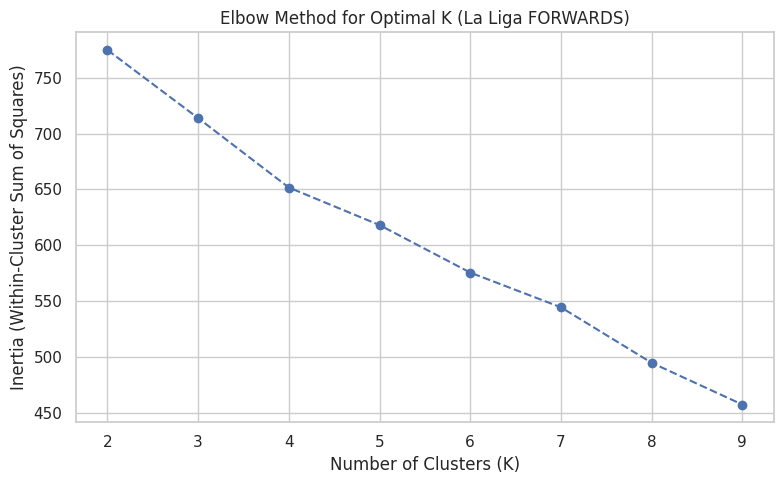

✅ Elbow Method plot generated. Look for the 'elbow' point to determine optimal K.
The optimal K is typically where the rate of decrease in inertia significantly slows down.


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Explanation:
# The Elbow Method is used to determine the optimal number of clusters (K)
# for a dataset. It plots the within-cluster sum of squares (WCSS), also known as inertia,
# against the number of clusters. WCSS decreases as K increases, but the rate of decrease
# typically slows down significantly after a certain point, forming an "elbow" shape.
# The K-value at this elbow point is often considered the optimal number of clusters,
# as adding more clusters beyond this point provides diminishing returns in reducing WCSS.

# Load the PCA transformed data.
# This data is the output of the 'Feature Engineering: PCA for Dimensionality Reduction - La Liga Forwards' step.
# We will use this lower-dimensional representation for clustering.
try:
    df_pca = pd.read_csv("laliga_forwards_2023_24_pca_transformed.csv")
    print("✅ PCA transformed data loaded successfully for Elbow Method.")
except FileNotFoundError:
    print("❌ Error: 'laliga_forwards_2023_24_pca_transformed.csv' not found.")
    print("Please ensure this file has been generated by the 'Feature Engineering: PCA for Dimensionality Reduction - La Liga Forwards' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# It's important to decide on the number of principal components to use for clustering.
# Based on the PCA explained variance plot for forwards, we identified that 16 components explain over 90% of the variance.
# We will use these 16 components as the input for the KMeans algorithm.
n_components_for_clustering = 16 # Adjusted for forwards based on previous PCA output
if n_components_for_clustering > df_pca.shape[1]:
    print(f"⚠️ Warning: Requested {n_components_for_clustering} components, but only {df_pca.shape[1]} are available.")
    n_components_for_clustering = df_pca.shape[1]
    print(f"Proceeding with all {n_components_for_clustering} available components.")

X_for_clustering = df_pca.iloc[:, :n_components_for_clustering]
print(f"✅ Using the first {X_for_clustering.shape[1]} principal components for clustering analysis.")


# Calculate WCSS (Inertia) for different numbers of clusters (K)
inertia = []
# Test K values from 2 to 9.
K_range = range(2, 10)

print(f"Calculating Inertia for K from {min(K_range)} to {max(K_range)}...")
for k in K_range:
    # Initialize KMeans with 'k-means++' for smart centroid initialization,
    # random_state for reproducibility, and n_init=10 for multiple runs to find the best centroids.
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_for_clustering)
    inertia.append(kmeans.inertia_) # inertia_ attribute stores the WCSS

print("✅ Inertia calculated for various K values.")

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal K (La Liga FORWARDS)") # Adjusted title
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.xticks(K_range) # Ensure x-axis ticks match the K_range
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ Elbow Method plot generated. Look for the 'elbow' point to determine optimal K.")
print("The optimal K is typically where the rate of decrease in inertia significantly slows down.")


Elbow Method Interpretation:

The Elbow Method plot shows the Within-Cluster Sum of Squares (WCSS), also known as Inertia, for different numbers of clusters (K). We look for an "elbow" where the decrease in WCSS slows down.

Based on the plot for La Liga Forwards, the curve shows a noticeable bend around K=3 or K=4. The decrease in Inertia is quite steep from K=2 to K=3 and then from K=3 to K=4. After K=4, the rate of decrease becomes less pronounced.

This suggests that 3 or 4 clusters might represent a good balance between minimizing WCSS and keeping the number of clusters manageable for interpretation of distinct forward roles.

#5.3 Silhouette Score-La Liga FORWARDS

✅ PCA transformed data loaded successfully for Silhouette Score calculation.
✅ Using the first 16 principal components for Silhouette Score calculation.
Calculating Silhouette Scores for K from 2 to 9...
✅ Silhouette Scores calculated for various K values.


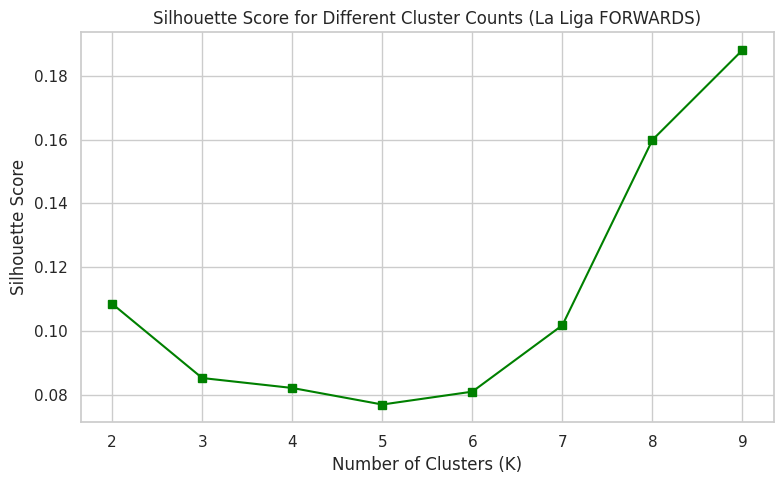

✅ Silhouette Score plot generated. Look for the highest score to determine optimal K.
A higher score indicates better-defined and more well-separated clusters.


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Explanation:
# The Silhouette Score is a metric used to evaluate the quality of clusters created
# by clustering algorithms like K-Means. It measures how similar an object is to its
# own cluster (cohesion) compared to other clusters (separation).
# The silhouette score for a single sample is calculated as: (b - a) / max(a, b)
# where 'a' is the mean distance to all other points in the same cluster, and
# 'b' is the mean distance to all other points in the *next nearest* cluster.
# The score ranges from -1 to +1:
#   +1: Indicates that the sample is far away from the neighboring clusters.
#    0: Indicates that the sample is on or very close to the decision boundary between two neighboring clusters.
#   -1: Indicates that the sample might have been assigned to the wrong cluster.
# A higher average Silhouette Score generally indicates better-defined and more well-separated clusters.

# Load the PCA transformed data.
# This data is the output of the 'Feature Engineering: PCA for Dimensionality Reduction - La Liga Forwards' step.
# We will use this lower-dimensional representation for clustering.
try:
    df_pca = pd.read_csv("laliga_forwards_2023_24_pca_transformed.csv")
    print("✅ PCA transformed data loaded successfully for Silhouette Score calculation.")
except FileNotFoundError:
    print("❌ Error: 'laliga_forwards_2023_24_pca_transformed.csv' not found.")
    print("Please ensure this file has been generated by the 'Feature Engineering: PCA for Dimensionality Reduction - La Liga Forwards' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Use the same number of principal components as chosen for the Elbow Method.
# Based on the PCA explained variance plot for forwards, we identified that 16 components explain over 90% of the variance.
n_components_for_clustering = 16 # Adjusted for forwards based on previous PCA output
if n_components_for_clustering > df_pca.shape[1]:
    print(f"⚠️ Warning: Requested {n_components_for_clustering} components, but only {df_pca.shape[1]} are available.")
    n_components_for_clustering = df_pca.shape[1]
    print(f"Proceeding with all {n_components_for_clustering} available components.")

X_for_clustering = df_pca.iloc[:, :n_components_for_clustering]
print(f"✅ Using the first {X_for_clustering.shape[1]} principal components for Silhouette Score calculation.")


# Calculate Silhouette Scores for different numbers of clusters (K)
silhouette_scores = []
# Use the same K_range as the Elbow Method for consistent comparison.
K_range = range(2, 10) # K_range for Silhouette Score must start from 2 (minimum for score calculation)

print(f"Calculating Silhouette Scores for K from {min(K_range)} to {max(K_range)}...")
for k in K_range:
    # Initialize KMeans with 'k-means++' for smart centroid initialization,
    # random_state for reproducibility, and n_init=10 for multiple runs to find the best centroids.
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_for_clustering) # Fit KMeans and get cluster labels
    score = silhouette_score(X_for_clustering, labels) # Calculate the silhouette score
    silhouette_scores.append(score)

print("✅ Silhouette Scores calculated for various K values.")

# Plotting Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='s', color='green')
plt.title("Silhouette Score for Different Cluster Counts (La Liga FORWARDS)") # Adjusted title
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.xticks(K_range) # Ensure x-axis ticks match the K_range
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ Silhouette Score plot generated. Look for the highest score to determine optimal K.")
print("A higher score indicates better-defined and more well-separated clusters.")


#Silhouette Score Interpretation:

The Silhouette Score measures how well-separated the clusters are. A higher score indicates better-defined and more distinct clusters.

Looking at the Silhouette Score plot:

Highest score: The plot shows that the highest Silhouette Score is achieved at K = 2.
Next best: The score decreases after K=2, with K=3 and K=4 showing successively lower scores.
Trend: The Silhouette Score generally decreases as the number of clusters increases beyond K=2.
Interpretation:

The Silhouette Score suggests that K=2 results in the best-separated clusters for this forward dataset, according to this metric. K=3 and K=4 show lower, but still potentially acceptable, separation.

## Choosing the Optimal K: Elbow Method vs. Silhouette Score

Combining the insights from the Elbow Method (which suggested K=3 or K=4 as potential elbows) and the Silhouette Score (which indicates K=2 as having the highest separation), there is a slight discrepancy. This is not uncommon, as different metrics can sometimes suggest different optimal K values.

Considering both methods, K=2, K=3, or K=4 are reasonable candidates for the number of clusters to explore further. The choice might depend on the desired level of granularity for defining forward roles.

I will choose k=3 for now.

#6. KMeans Training - La Liga FORWARDS

✅ PCA transformed data loaded successfully for K-Means clustering.
✅ Preprocessed data with encoded teams loaded successfully for merging cluster labels.
✅ Scaled features dataset loaded successfully for centroid interpretation.
✅ Using the first 16 principal components for K-Means training.
✅ K-Means clustering performed with K=3.

Distribution of players across 3 clusters:
Cluster
0    11
1     7
2    18

✅ Forwards data with cluster assignments saved as: laliga_forwards_2023_24_clustered.csv

First 5 rows of forwards data with cluster assignments:
            name  position  minutes  duels_total_api  duels_won_api  goals_total_api  shots_total_api  shots_on_target_api  assists_total_api  dribbles_attempts_api  dribbles_success_api  touches_total_api  passes_key_api  passes_total_api  passes_accuracy_perc  shots_on_target_perc  dribbles_success_perc     name_clean       team_clean  duels_total_p90  duels_won_p90  goals_p90  shots_total_p90  shots_on_target_p90  assists_p90  dribbles_

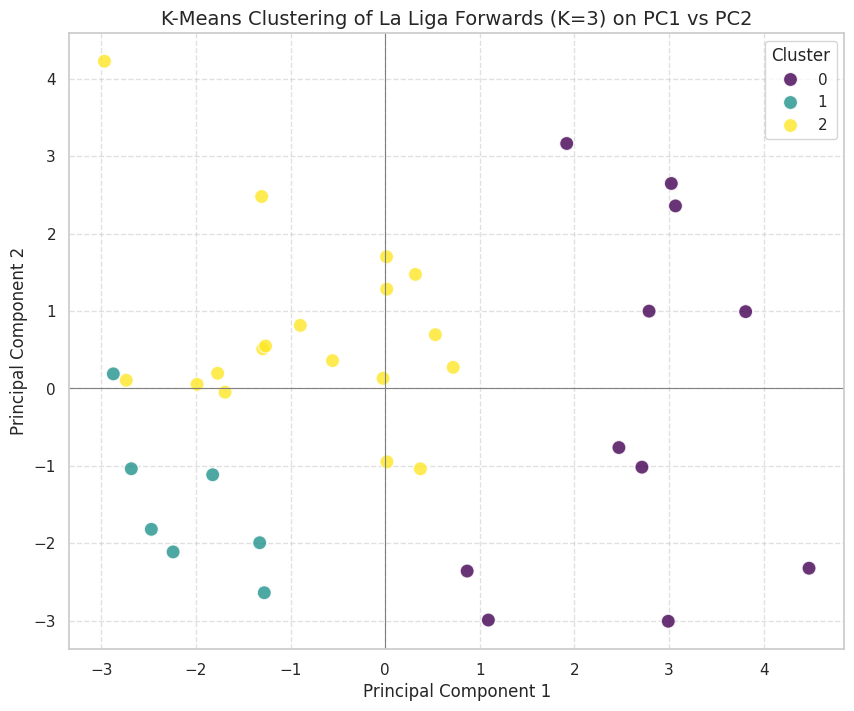

✅ Clustering visualization generated.

--- Cluster Interpretation: Mean Scaled Feature Values for Each Cluster ---
Cluster                       0         1             2
goals_p90              0.148351  1.055649 -5.011889e-01
shots_total_p90        0.342411  0.253683 -3.079055e-01
dribbles_attempts_p90  0.841032 -0.700471 -2.415586e-01
dribbles_success_p90   1.010327 -0.840824 -2.904353e-01
dribbles_success_perc  0.733673 -0.776737 -1.462911e-01
assists_p90            0.956656 -0.688813 -3.167511e-01
passes_key_p90         0.902615 -1.081697 -1.309381e-01
passes_total_p90       1.113309 -1.019140 -2.840230e-01
passes_accuracy_perc   0.690767  0.258704 -5.227428e-01
duels_total_p90       -0.198315 -0.602976  3.556833e-01
duels_won_p90          0.202764 -0.800556  1.874163e-01
team_Almeria          -0.242536 -0.242536  2.425356e-01
team_Athletic Club     0.027410 -0.301511  1.005038e-01
team_Atletico Madrid  -0.169031  0.700271 -1.690309e-01
team_Barcelona         0.685253 -0.301511 -3.

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Explanation:
# This step performs K-Means clustering on the PCA-transformed forwards data.
# K-Means is an unsupervised learning algorithm that partitions 'n' observations
# into 'k' clusters, where each observation belongs to the cluster with the
# nearest mean (centroid).
# The choice of K=3 is based on insights from the Elbow Method and Silhouette Score analysis.
# The output will be cluster labels for each forward, which will then be used
# to understand the distinct tactical roles.

# Load the PCA transformed data.
# This data is the output of the 'Feature Engineering: PCA for Dimensionality Reduction - La Liga Forwards' step.
# We will use this lower-dimensional representation for clustering.
try:
    df_pca = pd.read_csv("laliga_forwards_2023_24_pca_transformed.csv")
    print("✅ PCA transformed data loaded successfully for K-Means clustering.")
except FileNotFoundError:
    print("❌ Error: 'laliga_forwards_2023_24_pca_transformed.csv' not found.")
    print("Please ensure this file has been generated by the 'Feature Engineering: PCA for Dimensionality Reduction - La Liga Forwards' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Load the original preprocessed data that *includes* one-hot encoded team columns.
# This is crucial to ensure that all features used for clustering (including team)
# are present when merging back the cluster labels for full interpretability and centroid calculation.
try:
    df_forwards_preprocessed_encoded_team = pd.read_csv("laliga_forwards_2023_24_preprocessed_encoded_team.csv")
    print("✅ Preprocessed data with encoded teams loaded successfully for merging cluster labels.")
except FileNotFoundError:
    print("❌ Error: 'laliga_forwards_2023_24_preprocessed_encoded_team.csv' not found.")
    print("Please ensure this file has been generated by the 'Feature Engineering: One-Hot Encoding Team Column for Forwards' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Load the scaled features dataset.
# This is crucial for interpreting cluster centroids in terms of the original scaled features.
try:
    df_scaled_features = pd.read_csv("laliga_forwards_2023_24_scaled_metrics.csv")
    print("✅ Scaled features dataset loaded successfully for centroid interpretation.")
except FileNotFoundError:
    print("❌ Error: 'laliga_forwards_2023_24_scaled_metrics.csv' not found.")
    print("Please ensure this file has been generated by the 'Feature Engineering: Feature Scaling - Standardizing Numerical Metrics for Forwards' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()


# Use the same number of principal components as chosen for the Elbow and Silhouette Methods.
# Based on the PCA explained variance plot for forwards, we identified that 16 components explain over 90% of the variance.
n_components_for_clustering = 16 # Adjusted for forwards based on previous PCA output
if n_components_for_clustering > df_pca.shape[1]:
    print(f"⚠️ Warning: Requested {n_components_for_clustering} components, but only {df_pca.shape[1]} are available.")
    n_components_for_clustering = df_pca.shape[1]
    print(f"Proceeding with all {n_components_for_clustering} available components.")

X_for_clustering = df_pca.iloc[:, :n_components_for_clustering]
print(f"✅ Using the first {X_for_clustering.shape[1]} principal components for K-Means training.")

# Initialize and train the K-Means model with K=3.
# 'k-means++' for smart centroid initialization.
# 'random_state' for reproducibility of results.
# 'n_init=10' runs the algorithm 10 times with different centroid seeds and chooses the best result.
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)

# Fit the KMeans model to the PCA-transformed data and predict cluster labels
cluster_labels = kmeans.fit_predict(X_for_clustering)
print(f"✅ K-Means clustering performed with K={n_clusters}.")

# Add the cluster labels back to the DataFrame that includes all features, including encoded teams.
# This ensures that when 'laliga_forwards_2023_24_clustered.csv' is saved, it contains all features
# necessary for correct centroid calculation later.
df_forwards_final_with_clusters = df_forwards_preprocessed_encoded_team.copy()
df_forwards_final_with_clusters['Cluster'] = cluster_labels

# Display the count of players in each cluster
print(f"\nDistribution of players across {n_clusters} clusters:")
print(df_forwards_final_with_clusters['Cluster'].value_counts().sort_index().to_string())

# Save the DataFrame with cluster assignments
output_filename_with_clusters = "laliga_forwards_2023_24_clustered.csv" # Adjusted filename
df_forwards_final_with_clusters.to_csv(output_filename_with_clusters, index=False)
print(f"\n✅ Forwards data with cluster assignments saved as: {output_filename_with_clusters}") # Adjusted message

# Display first few rows with the new 'Cluster' column
print("\nFirst 5 rows of forwards data with cluster assignments:") # Adjusted message
print(df_forwards_final_with_clusters.head().to_string())

# --- Clustering Visualization ---
# Explanation:
# This scatter plot visualizes the clusters in a 2D space using the first two
# principal components (PC1 and PC2). Each point represents a forward, # Adjusted message
# colored according to their assigned cluster. This helps to visually assess
# the separation and distribution of the clusters.
print("\n--- Generating Clustering Visualization ---")

# Add cluster labels to the df_pca DataFrame for plotting
df_pca_with_clusters = df_pca.copy()
df_pca_with_clusters['Cluster'] = cluster_labels

# Plotting the clusters using PC1 and PC2
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Cluster',
    data=df_pca_with_clusters,
    palette='viridis', # A color palette suitable for distinct clusters
    s=100,             # Size of the points
    alpha=0.8,         # Transparency of the points
    edgecolor='w',     # White edge for better distinction
    legend='full'      # Show the full legend
)
plt.title(f'K-Means Clustering of La Liga Forwards (K={n_clusters}) on PC1 vs PC2', fontsize=14) # Adjusted title
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(0, color='grey', linewidth=0.8)
plt.axvline(0, color='grey', linewidth=0.8)
plt.show()

print("✅ Clustering visualization generated.")

# --- Cluster Interpretation: Centroid Analysis ---
# Explanation:
# To understand the characteristics of each cluster, we examine the mean values
# of the *scaled* features for all players within that cluster. Since the features
# are scaled (mean=0, std=1), positive values indicate above-average performance
# for that feature in the cluster, and negative values indicate below-average performance.
# This allows us to define the "profile" or "archetype" of forwards in each cluster. # Adjusted message
print("\n--- Cluster Interpretation: Mean Scaled Feature Values for Each Cluster ---")

# Add cluster labels to the scaled features DataFrame
df_scaled_features_with_clusters = df_scaled_features.copy()
df_scaled_features_with_clusters['Cluster'] = cluster_labels

# Calculate the mean of each scaled feature for each cluster
cluster_centroids_scaled = df_scaled_features_with_clusters.groupby('Cluster').mean()

# Display the scaled centroids
# Use .T (transpose) for better readability if you have many features
print(cluster_centroids_scaled.T.to_string())

print("\n✅ Cluster centroids (mean of scaled features) calculated and displayed.")
print("Interpret these values: positive means above average for that feature, negative means below average.")
print("This table is key to defining the tactical profiles of each forward cluster.")


# La Liga Forward Cluster Profiles (K=3)

Based on the analysis of scaled feature centroids, we've identified three distinct tactical profiles among La Liga forwards:

# Cluster 0: The Dribbling Playmaker

Forwards in Cluster 0 demonstrate above-average performance in several key areas. They stand out with significantly high scaled values for dribbles_attempts_p90, dribbles_success_p90, and dribbles_success_perc, indicating they are frequent and successful dribblers. They also show strong contributions in playmaking, with above-average assists_p90 and passes_key_p90, and higher involvement in overall passing (passes_total_p90) with good passes_accuracy_perc. Their goal-scoring (goals_p90) and shooting volume (shots_total_p90) are slightly above average, but their defining traits are ball progression through dribbling and creating chances for others. Their engagement in duels (duels_total_p90, duels_won_p90) is around average or slightly below.

# Cluster 1: The Prolific Scorer

Cluster 1 is characterized by forwards with exceptionally high goal-scoring rates. Their goals_p90 scaled values are significantly positive, marking them as the primary finishers. While their shots_total_p90 is also above average, it's their conversion and ability to find the back of the net that defines this group. In contrast to Cluster 0, they show below-average performance in most other metrics, including dribbling (dribbles_attempts_p90, dribbles_success_p90, dribbles_success_perc), playmaking (assists_p90, passes_key_p90), and passing volume (passes_total_p90). Their passing accuracy (passes_accuracy_perc) and duel engagement (duels_total_p90, duels_won_p90) are around average or below.

# Cluster 2: The Link-up & Engagement Forward

Forwards in Cluster 2 are defined by their involvement in link-up play and offensive engagement. They show below-average contributions in goal-scoring (goals_p90) and shooting volume (shots_total_p90), as well as dribbling (dribbles_attempts_p90, dribbles_success_p90, dribbles_success_perc) and playmaking (assists_p90, passes_key_p90). Their passing accuracy (passes_accuracy_perc) is below average, but they exhibit above-average engagement in duels (duels_total_p90, duels_won_p90), suggesting a role that involves physical contests, potentially holding up the ball or contributing to pressing. Their overall passing volume (passes_total_p90) is below average, which, combined with lower accuracy, suggests less involvement in intricate build-up, but their duel engagement points to a different type of offensive contribution.

Comment on the Visualization:

The scatter plot of the clusters on PC1 vs PC2 shows some visual separation between the three clusters, although there is some overlap, particularly between Cluster 0 and Cluster 2. Cluster 1 appears somewhat distinct, generally positioned differently on the PC1 and PC2 axes compared to the other two clusters. This visualization in a reduced dimensional space provides a glimpse into the separability of the identified profiles, supporting the idea that these clusters represent somewhat distinct groupings based on the underlying performance metrics.

These profiles offer a data-driven understanding of the diverse roles played by forwards in La Liga, moving beyond traditional labels to describe their contributions based on quantifiable actions on the pitch.